<a href="https://colab.research.google.com/github/god-konw/magincan-s-home/blob/master/2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/Colab Notebooks/'

**Functions**

In [35]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from sklearn import model_selection
from sklearn.model_selection import train_test_split

from prettytable import PrettyTable  # To print in tabular format
from sklearn.metrics import confusion_matrix, make_scorer  # Scoring functions
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, roc_curve, accuracy_score, auc, confusion_matrix
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns


from sklearn import linear_model, neighbors, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb  #XGB


import pickle

sns.set_style("whitegrid")

In [4]:
"""
def false_alarm_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm ratE
"""

In [97]:
del result_dict

In [9]:
result_dict = {"Model":[], "AUC":[], "F1-score":[], "Recall":[], "Precision":[], "Accuracy":[]}

In [76]:
result_dict

{'Model': [],
 'AUC': [],
 'F1-score': [],
 'Recall': [],
 'Precision': [],
 'Accuracy': []}

In [43]:
def hyperparam_tuning(clf, parameters, x, y, method='gridsearch', cv=None):

    # initialization
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'recall':'recall',
               'precision':'precision',
               'accuracy':'accuracy'} 
                
    # param tuning
    if method=='gridsearch':
        # As we are using multi scoring, So we need to point refit to scoring function with which we want to evaluate score
        tuning_clf = GridSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                  cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)
    else:
        result = None
    """ 
    elif method=='randomsearch':
        tuning_clf = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                        cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)
    """ 
   

    return result

In [28]:
def result_visualization(model_name, tuned_clf, parameters, param1=None, param2=None):

    # getting train and test scores to plot
    train_score = tuned_clf.cv_results_['mean_train_auc']
    test_score = tuned_clf.cv_results_['mean_test_auc']

    # print results
    print("Best Score: {}".format(tuned_clf.best_score_))
    print("Best Parameters: {}".format(tuned_clf.best_params_))

    # Want to visualize score with 2 params, plot heatmap of the 3 variables
    if param2 is not None:
        # heatmap
        train_cmap=sns.light_palette("green")
        test_cmap=sns.light_palette("blue")
        
        # Figure and axis
        fig = plt.figure(figsize=(20,5))
        train_ax = fig.add_subplot(1,2,1)
        test_ax = fig.add_subplot(1,2,2)
        
        # train heatmap
        sns.heatmap(train_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # test heapmap
        sns.heatmap(test_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=test_cmap, annot=True, fmt='.6f', ax=test_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # axis labels and plot title
        train_ax.set_title("Train hyperparam heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        test_ax.set_title("Test hyperparam heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)

        plt.savefig(path+f"/pic/{model_name}+{param1}+{param2}_heatmap.png")
        plt.show()
    
    # Want to visualize score with one param, simply plot score and param
    else:
        plt.figure(figsize=(10,5))
        plt.plot(np.log10(parameters[param1]), train_score, label="train")
        plt.plot(np.log10(parameters[param1]), test_score, label="test")
        #plt.bar(parameters[param1], train_score, label="train")
        #plt.bar(parameters[param1], test_score, label="test")
        # Plot for train data
        for i, txt in enumerate(train_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], train_score[i]))
        
        # Plot for test data
        for i, txt in enumerate(test_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], test_score[i]))
        
        plt.xlabel(param1)
        plt.ylabel('performance')
        plt.grid()
        plt.legend()
        #plt.title(f"Performance vs {param1}")
        plt.savefig(path+f"/pic/{model_name}+{param1}_performance.png")
        plt.show()

In [12]:
def evaluate_result(model_name, clf, x_train, y_train, x_test, y_test):

    cmap=sns.light_palette("blue")
    labels= ['normal', 'malicious']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # roc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = roc_auc_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = roc_auc_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # return finall socres to result_dict
    result_dict['Model'].append(model_name)
    result_dict['AUC'].append(test_auc)
    result_dict['F1-score'].append(test_f1)
    result_dict['Recall'].append(test_recall)
    result_dict['Precision'].append(test_precision)
    result_dict['Accuracy'].append(test_accuracy)

    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'Recall', 'Precision', 'Accuracy']
    x.add_row(['Train', model_name, train_auc, train_f1, train_recall, train_precision, train_accuracy])
    x.add_row(['Test', model_name, test_auc, test_f1,test_recall, test_precision, test_accuracy])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.savefig(path+f"/pic/{model_name}_auc_curve.png")
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")  
    plt.savefig(path+f"/pic/{model_name}_confusion_matrix.png")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_recall, test_precision, test_accuracy, result_dict

In [13]:
X = pd.read_csv(path+'datasets/p2_train.csv')
y = pd.read_csv(path+'datasets/p2_test.csv')
df = X.join(y)
train= df.copy(deep=True)

In [14]:
del df, X, y
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
del train

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

**Models**

**LR with SGDClassifier**

In [102]:
lr_1 = LogisticRegression(penalty='l2')
param = {'C':[100,10,1.0,0.1,0.01]} 

         #,'solvers':['newton-cg','lbfgs','liblinear']
lr_clf_1 = hyperparam_tuning(lr_1, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=100; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.990) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=100; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.920) recall: (train=0.990, test=0.989) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=100; accuracy: (train=0.934, test=0.933) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.920, test=0.918) recall: (train=0.989, test=0.991) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=100; accuracy: (train=0.934, test=0.930) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.951) precision: (train=0.919, test=0.914) recall: (train=0.990, test=0.990) total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=100; accuracy: (train=0.934, test=0.933) auc: (train=0.983, test=0.980) f1: (train=0.953, test=0.952) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.988) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=100; accuracy: (train=0.934, test=0.933) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.918) recall: (train=0.990, test=0.991) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=100; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.990) total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=100; accuracy: (train=0.933, test=0.935) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.922) recall: (train=0.990, test=0.989) total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=100; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.920) recall: (train=0.990, test=0.990) total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=100; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.920) recall: (train=0.989, test=0.990) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=10; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.989, test=0.989) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=10; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.920) recall: (train=0.990, test=0.989) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=10; accuracy: (train=0.934, test=0.933) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.918) recall: (train=0.990, test=0.991) total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=10; accuracy: (train=0.934, test=0.930) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.951) precision: (train=0.919, test=0.914) recall: (train=0.990, test=0.990) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=10; accuracy: (train=0.934, test=0.932) auc: (train=0.983, test=0.980) f1: (train=0.953, test=0.952) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.988) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=10; accuracy: (train=0.934, test=0.933) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.952) precision: (train=0.919, test=0.918) recall: (train=0.989, test=0.990) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=10; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.920) recall: (train=0.989, test=0.989) total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=10; accuracy: (train=0.933, test=0.935) auc: (train=0.982, test=0.982) f1: (train=0.952, test=0.954) precision: (train=0.918, test=0.921) recall: (train=0.989, test=0.988) total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=10; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.918, test=0.919) recall: (train=0.991, test=0.990) total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=10; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.920) recall: (train=0.990, test=0.990) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=1.0; accuracy: (train=0.933, test=0.933) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.989, test=0.989) total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=1.0; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.918, test=0.920) recall: (train=0.989, test=0.989) total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=1.0; accuracy: (train=0.933, test=0.933) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.917) recall: (train=0.990, test=0.991) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=1.0; accuracy: (train=0.934, test=0.930) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.950) precision: (train=0.919, test=0.914) recall: (train=0.990, test=0.990) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=1.0; accuracy: (train=0.933, test=0.932) auc: (train=0.983, test=0.980) f1: (train=0.953, test=0.952) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.988) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=1.0; accuracy: (train=0.933, test=0.932) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.952) precision: (train=0.919, test=0.917) recall: (train=0.989, test=0.990) total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=1.0; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.989, test=0.990) total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=1.0; accuracy: (train=0.933, test=0.935) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.922) recall: (train=0.989, test=0.989) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=1.0; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.918, test=0.919) recall: (train=0.990, test=0.990) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=1.0; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.918, test=0.920) recall: (train=0.990, test=0.990) total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=0.1; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.981) f1: (train=0.952, test=0.953) precision: (train=0.917, test=0.918) recall: (train=0.990, test=0.991) total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=0.1; accuracy: (train=0.933, test=0.933) auc: (train=0.981, test=0.982) f1: (train=0.952, test=0.953) precision: (train=0.917, test=0.918) recall: (train=0.990, test=0.990) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=0.1; accuracy: (train=0.933, test=0.932) auc: (train=0.981, test=0.982) f1: (train=0.952, test=0.952) precision: (train=0.917, test=0.916) recall: (train=0.990, test=0.992) total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=0.1; accuracy: (train=0.933, test=0.929) auc: (train=0.981, test=0.981) f1: (train=0.953, test=0.950) precision: (train=0.918, test=0.912) recall: (train=0.990, test=0.991) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=0.1; accuracy: (train=0.933, test=0.932) auc: (train=0.982, test=0.979) f1: (train=0.952, test=0.952) precision: (train=0.917, test=0.918) recall: (train=0.990, test=0.988) total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=0.1; accuracy: (train=0.933, test=0.932) auc: (train=0.982, test=0.981) f1: (train=0.952, test=0.952) precision: (train=0.917, test=0.916) recall: (train=0.990, test=0.990) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=0.1; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.982) f1: (train=0.952, test=0.953) precision: (train=0.917, test=0.918) recall: (train=0.990, test=0.991) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=0.1; accuracy: (train=0.932, test=0.934) auc: (train=0.982, test=0.981) f1: (train=0.952, test=0.954) precision: (train=0.917, test=0.920) recall: (train=0.990, test=0.989) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=0.1; accuracy: (train=0.933, test=0.933) auc: (train=0.981, test=0.982) f1: (train=0.952, test=0.952) precision: (train=0.917, test=0.918) recall: (train=0.990, test=0.990) total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=0.1; accuracy: (train=0.933, test=0.934) auc: (train=0.981, test=0.983) f1: (train=0.952, test=0.953) precision: (train=0.917, test=0.919) recall: (train=0.990, test=0.990) total time=   3.3s
[CV 1/10] END C=0.01; accuracy: (train=0.931, test=0.930) auc: (train=0.978, test=0.978) f1: (train=0.951, test=0.951) precision: (train=0.914, test=0.914) recall: (train=0.992, test=0.991) total time=   2.4s
[CV 2/10] END C=0.01; accuracy: (train=0.931, test=0.931) auc: (train=0.978, test=0.978) f1: (train=0.951, test=0.952) precision: (train=0.914, test=0.915) recall: (train=0.992, test=0.992) total time=   2.4s
[CV 3/10] END C=0.01; accuracy: (train=0.931, test=0.931) auc: (train=0.978, test=0.979) f1: (train=0.951, test=0.952) precision: (train=0.914, test=0.914) recall: (train=0.992, test=0.993) total time=   2.3s
[CV 4/10] END C=0.01; accuracy: (train=0.931, test=0.927) auc: (train=0.978, test=0.978) f1: (train=0.952, test=0.949) precision: (train=0.914, test=0.909) recall: 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Score: 0.9823049752047581
Best Parameters: {'C': 10}


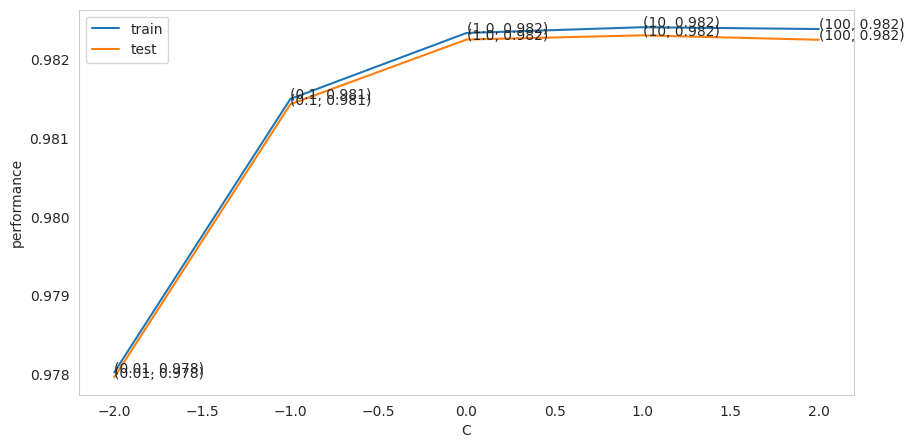

In [117]:
# Plotting alpha vs score
result_visualization('LR_1', lr_clf_1, param, param1='C')

In [118]:
lr_2 = LogisticRegression(penalty='l2')
param = {'C':[10] ,
        'solver':['newton-cg','lbfgs','liblinear']}
lr_clf_2 = hyperparam_tuning(lr_2, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END C=10, solver=newton-cg; accuracy: (train=0.934, test=0.934) auc: (train=0.983, test=0.982) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.990) total time=  24.2s
[CV 2/10] END C=10, solver=newton-cg; accuracy: (train=0.934, test=0.935) auc: (train=0.983, test=0.983) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.921) recall: (train=0.990, test=0.989) total time=  25.8s
[CV 3/10] END C=10, solver=newton-cg; accuracy: (train=0.934, test=0.934) auc: (train=0.983, test=0.983) f1: (train=0.954, test=0.953) precision: (train=0.919, test=0.918) recall: (train=0.990, test=0.992) total time=  25.5s
[CV 4/10] END C=10, solver=newton-cg; accuracy: (train=0.935, test=0.931) auc: (train=0.983, test=0.982) f1: (train=0.954, test=0.952) precision: (train=0.920, test=0.915) recall: (train=0.991, test=0.991) total time=  28.6s
[CV 5/10] END C=10, solver=newton-cg; a

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=10, solver=lbfgs; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.989, test=0.989) total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=10, solver=lbfgs; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.920) recall: (train=0.990, test=0.989) total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=10, solver=lbfgs; accuracy: (train=0.934, test=0.933) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.918) recall: (train=0.990, test=0.991) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=10, solver=lbfgs; accuracy: (train=0.934, test=0.930) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.951) precision: (train=0.919, test=0.914) recall: (train=0.990, test=0.990) total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=10, solver=lbfgs; accuracy: (train=0.934, test=0.932) auc: (train=0.983, test=0.980) f1: (train=0.953, test=0.952) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.988) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=10, solver=lbfgs; accuracy: (train=0.934, test=0.933) auc: (train=0.982, test=0.982) f1: (train=0.953, test=0.952) precision: (train=0.919, test=0.918) recall: (train=0.989, test=0.990) total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=10, solver=lbfgs; accuracy: (train=0.933, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.920) recall: (train=0.989, test=0.989) total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=10, solver=lbfgs; accuracy: (train=0.933, test=0.935) auc: (train=0.982, test=0.982) f1: (train=0.952, test=0.954) precision: (train=0.918, test=0.921) recall: (train=0.989, test=0.988) total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=10, solver=lbfgs; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.953) precision: (train=0.918, test=0.919) recall: (train=0.991, test=0.990) total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=10, solver=lbfgs; accuracy: (train=0.934, test=0.934) auc: (train=0.982, test=0.983) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.920) recall: (train=0.990, test=0.990) total time=   3.1s
[CV 1/10] END C=10, solver=liblinear; accuracy: (train=0.934, test=0.934) auc: (train=0.983, test=0.982) f1: (train=0.953, test=0.953) precision: (train=0.919, test=0.919) recall: (train=0.990, test=0.990) total time=  19.7s
[CV 2/10] END C=10, solver=liblinear; accuracy: (train=0.934, test=0.935) auc: (train=0.983, test=0.983) f1: (train=0.953, test=0.954) precision: (train=0.919, test=0.921) recall: (train=0.990, test=0.989) total time=  21.4s
[CV 3/10] END C=10, solver=liblinear; accuracy: (train=0.934, test=0.934) auc: (train=0.983, test=0.983) f1: (train=0.954, test=0.953) precision: (train=0.919, test=0.918) recall: (train=0.990, test=0.992) total time=  18.3s
[CV 4/10] END C=10, solver=liblinear; accuracy: (train=0.935, test=0.931) auc: (train=0.983, test=0.982

Best Score: 0.9827176212392359
Best Parameters: {'C': 10, 'solver': 'newton-cg'}


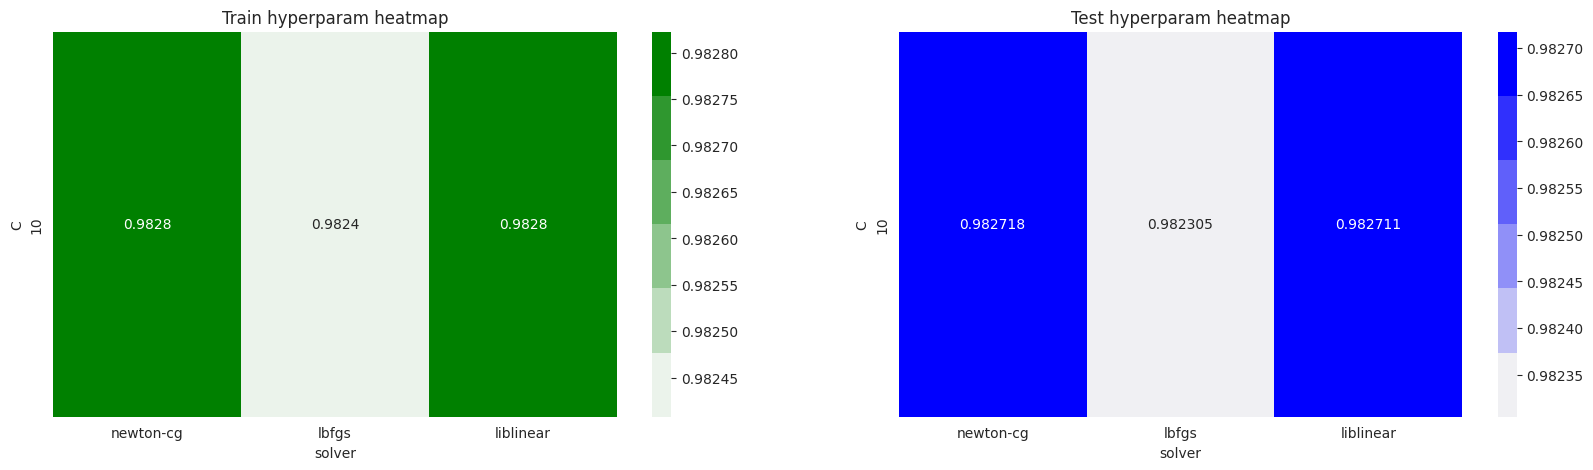

In [119]:
# Plotting alpha vs score
result_visualization('LR_l2', lr_clf_2, param, param1='C', param2='solver')

In [64]:
# Best LR model
lr_bst_clf = LogisticRegression(C=10, solver='newton-cg')

+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset | Model |        AUC         |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  |   LR  | 0.9028180898892635 | 0.9536255108687507 | 0.9905041312417675 | 0.9193944580911203 | 0.9344538773647934 |
|   Test  |   LR  | 0.9037510449240862 | 0.9536448799397007 | 0.9886969384052915 | 0.9209931106200442 | 0.9345284489477786 |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+


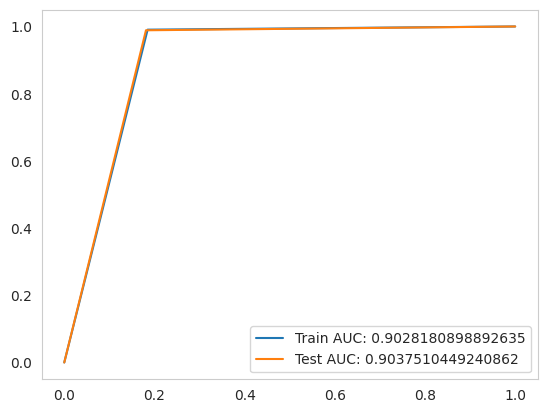

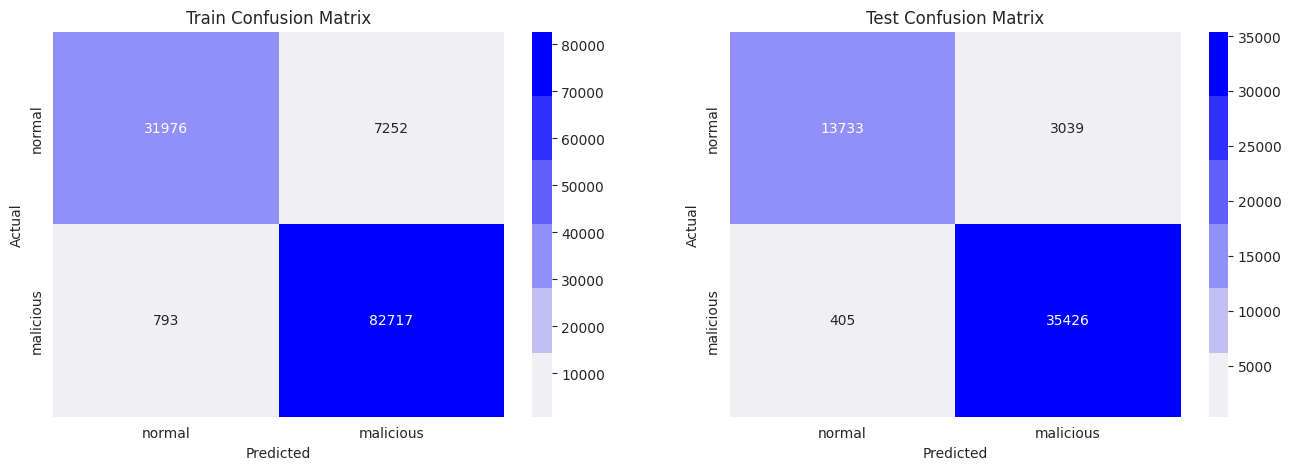

(LogisticRegression(C=10, solver='newton-cg'),
 0.9037510449240862,
 0.9536448799397007,
 0.9886969384052915,
 0.9209931106200442,
 0.9345284489477786,
 {'Model': ['RF', 'XGB', 'LR'],
  'AUC': [0.9393536854780613, 0.9464894309703068, 0.9037510449240862],
  'F1-score': [0.9669216797842478, 0.9684003272278532, 0.9536448799397007],
  'Recall': [0.980603388127599, 0.9746029974044822, 0.9886969384052915],
  'Precision': [0.9536165015605916, 0.96227610912097, 0.9209931106200442],
  'Accuracy': [0.9542991844571602, 0.956675474782807, 0.9345284489477786]})

In [65]:
# Getting best model's performance on train and test data
evaluate_result('LR', lr_bst_clf, X_train, y_train, X_test, y_test)

In [122]:
pickle.dump(lr_bst_clf, open(path+'models/LR_clf.pkl', 'wb'))

**SVC**

In [68]:
# Tuning "alpha" and "penalty"
svm = SGDClassifier(loss='hinge')
param = {'alpha':[10**x for x in range(-5,3)],  # Values for alpha
         'penalty':['l1', 'l2']}  # l1 an d l2 penalty

svm_clf = hyperparam_tuning(svm, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END alpha=1e-05, penalty=l1; accuracy: (train=0.934, test=0.935) auc: (train=0.980, test=0.979) f1: (train=0.954, test=0.954) precision: (train=0.919, test=0.919) recall: (train=0.991, test=0.992) total time=   7.2s
[CV 2/10] END alpha=1e-05, penalty=l1; accuracy: (train=0.932, test=0.934) auc: (train=0.979, test=0.980) f1: (train=0.951, test=0.953) precision: (train=0.928, test=0.931) recall: (train=0.976, test=0.976) total time=   5.1s
[CV 3/10] END alpha=1e-05, penalty=l1; accuracy: (train=0.932, test=0.933) auc: (train=0.978, test=0.979) f1: (train=0.952, test=0.952) precision: (train=0.921, test=0.920) recall: (train=0.985, test=0.987) total time=   5.9s
[CV 4/10] END alpha=1e-05, penalty=l1; accuracy: (train=0.932, test=0.927) auc: (train=0.978, test=0.978) f1: (train=0.951, test=0.948) precision: (train=0.927, test=0.922) recall: (train=0.977, test=0.976) total time=   6.5s
[CV 5/10] END alpha=1e-05, penalt

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 6/10] END alpha=10, penalty=l1; accuracy: (train=0.320, test=0.320) auc: (train=0.500, test=0.500) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) total time=   2.7s
[CV 7/10] END alpha=10, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   1.1s
[CV 8/10] END alpha=10, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   2.7s
[CV 9/10] END alpha=10, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   3.0s
[CV 10/10] END alpha=10, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/10] END alpha=100, penalty=l1; accuracy: (train=0.320, test=0.320) auc: (train=0.500, test=0.500) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) total time=   1.2s
[CV 2/10] END alpha=100, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   1.1s
[CV 3/10] END alpha=100, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   1.1s
[CV 4/10] END alpha=100, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   1.1s
[CV 5/10] END alpha=100, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 8/10] END alpha=100, penalty=l1; accuracy: (train=0.320, test=0.320) auc: (train=0.500, test=0.500) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) total time=   1.1s
[CV 9/10] END alpha=100, penalty=l1; accuracy: (train=0.680, test=0.680) auc: (train=0.500, test=0.500) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 10/10] END alpha=100, penalty=l1; accuracy: (train=0.320, test=0.320) auc: (train=0.500, test=0.500) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) total time=   1.1s
[CV 1/10] END alpha=100, penalty=l2; accuracy: (train=0.680, test=0.680) auc: (train=0.871, test=0.871) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   0.8s
[CV 2/10] END alpha=100, penalty=l2; accuracy: (train=0.680, test=0.680) auc: (train=0.871, test=0.871) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   0.8s
[CV 3/10] END alpha=100, penalty=l2; accuracy: (train=0.680, test=0.680) auc: (train=0.872, test=0.869) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   0.8s
[CV 4/10] END alpha=100, penalty=l2; accuracy: (train=0.680, test=0.680) auc: (train=0.872, test=0.868)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 9/10] END alpha=100, penalty=l2; accuracy: (train=0.320, test=0.320) auc: (train=0.871, test=0.871) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) total time=   0.8s
[CV 10/10] END alpha=100, penalty=l2; accuracy: (train=0.680, test=0.680) auc: (train=0.871, test=0.872) f1: (train=0.810, test=0.810) precision: (train=0.680, test=0.680) recall: (train=1.000, test=1.000) total time=   0.8s


Best Score: 0.9787742335643076
Best Parameters: {'alpha': 0.0001, 'penalty': 'l1'}


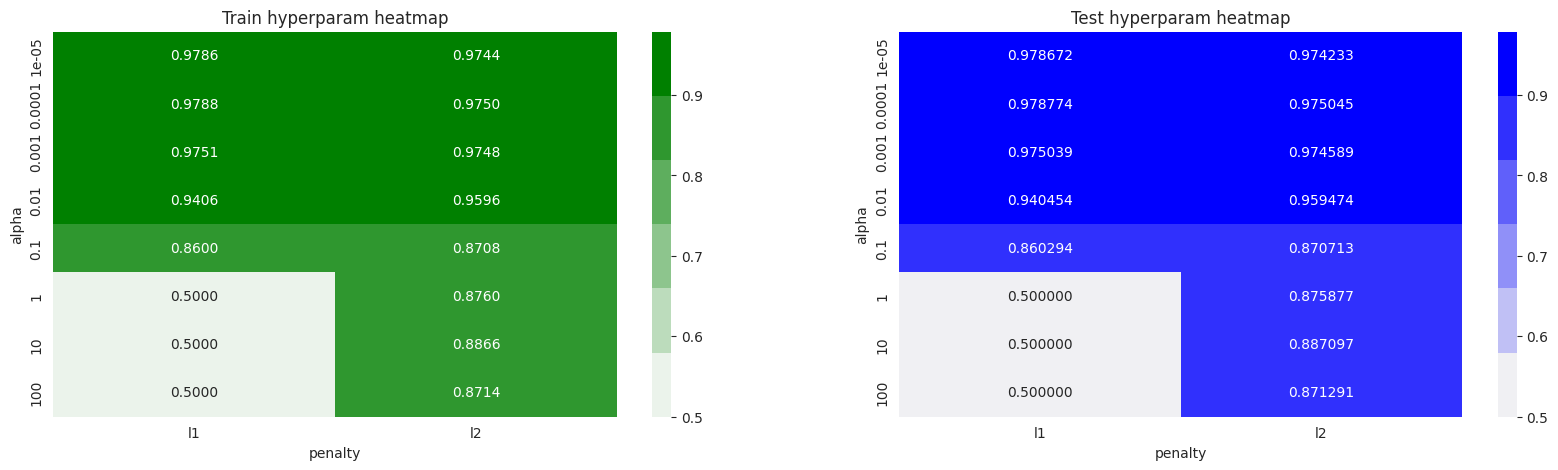

In [69]:
result_visualization('SVM', svm_clf, param, 'alpha', 'penalty')

In [70]:
best_svm_clf = svm_clf.best_estimator_

+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset | Model |        AUC         |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  |  SVM  | 0.9007888672160629 | 0.9533443363946379 | 0.9925637648185845 | 0.9171064714929023 | 0.9338998517166648 |
|   Test  |  SVM  | 0.9015849509312749 | 0.9535120916874681 | 0.9914599090173314 | 0.9183620711940645 | 0.9341482424956752 |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+


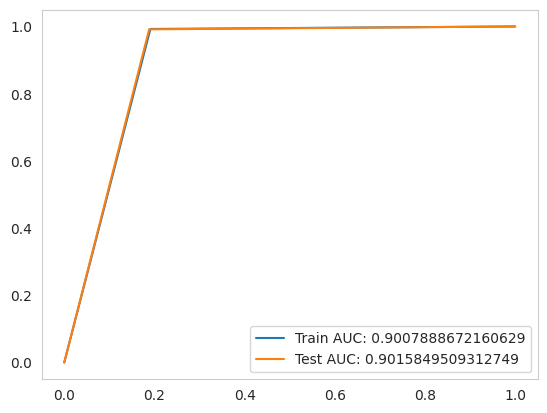

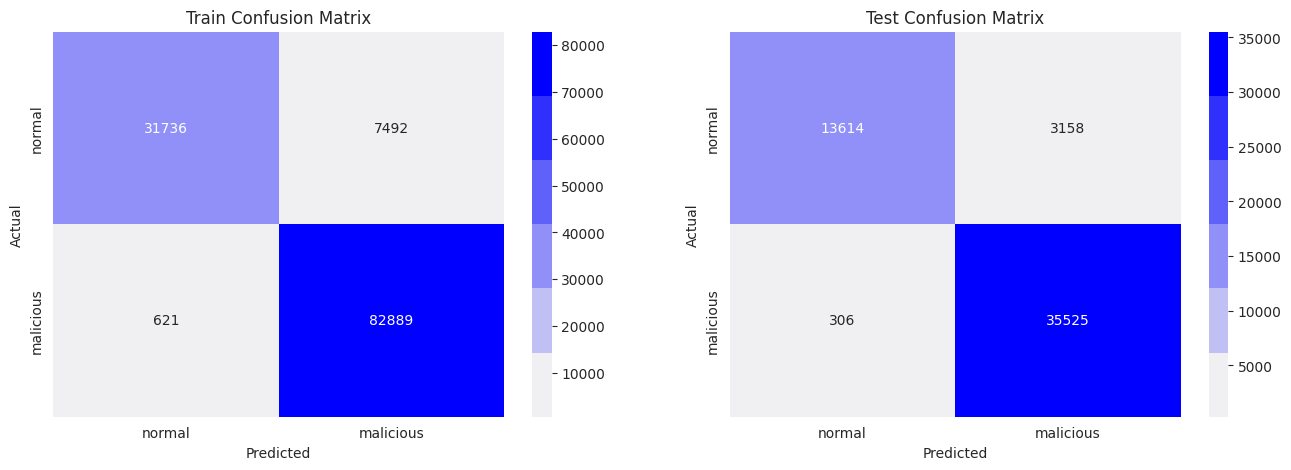

(SGDClassifier(penalty='l1'),
 0.9015849509312749,
 0.9535120916874681,
 0.9914599090173314,
 0.9183620711940645,
 0.9341482424956752,
 {'Model': ['RF', 'XGB', 'LR', 'SVM'],
  'AUC': [0.9393536854780613,
   0.9464894309703068,
   0.9037510449240862,
   0.9015849509312749],
  'F1-score': [0.9669216797842478,
   0.9684003272278532,
   0.9536448799397007,
   0.9535120916874681],
  'Recall': [0.980603388127599,
   0.9746029974044822,
   0.9886969384052915,
   0.9914599090173314],
  'Precision': [0.9536165015605916,
   0.96227610912097,
   0.9209931106200442,
   0.9183620711940645],
  'Accuracy': [0.9542991844571602,
   0.956675474782807,
   0.9345284489477786,
   0.9341482424956752]})

In [71]:
# Model performance on train and test
evaluate_result("SVM",best_svm_clf, X_train, y_train, X_test, y_test )

In [130]:
pickle.dump(best_svm_clf, open(path+'models/svm_clf.pkl', 'wb'))

**Decision Tree**

In [139]:
dt_tuni_1 = DecisionTreeClassifier()
param = {#criterion='gini''entropy'],
        'max_depth' : [2,6,8,12]
        ,'min_samples_split': [2,3]
        #,'min_samples_leaf': [1]
         }
dt_clf_tuni_1 = hyperparam_tuning(dt_tuni_1, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.920) auc: (train=0.929, test=0.929) f1: (train=0.945, test=0.944) precision: (train=0.896, test=0.895) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 2/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.921) auc: (train=0.929, test=0.929) f1: (train=0.945, test=0.945) precision: (train=0.896, test=0.896) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 3/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.921) auc: (train=0.929, test=0.931) f1: (train=0.945, test=0.945) precision: (train=0.896, test=0.896) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 4/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.917) auc: (train=0.929, test=0.925) f1: (train=0.945, test=0.943) precision: (train=0.896, test=0.892) recall: (train=1.000, test=1.000) total time=   0.5s

Best Score: 0.9858809741878188
Best Parameters: {'max_depth': 8, 'min_samples_split': 2}


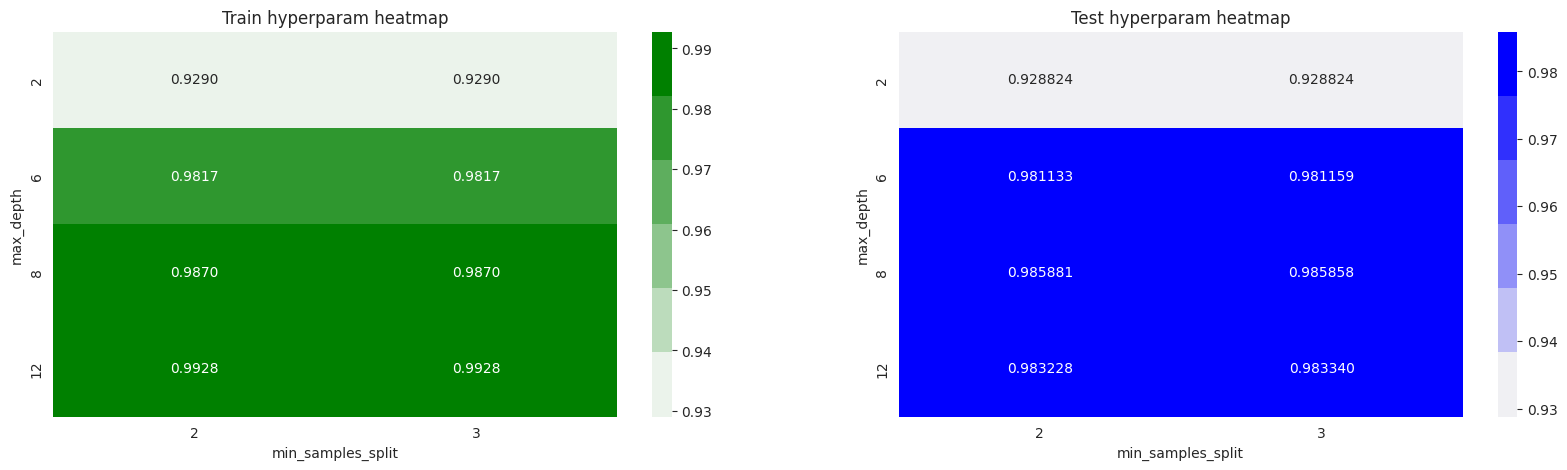

In [140]:
param = {#'entropy']
        'max_depth' : [2,6,8,12]
        ,'min_samples_split': [2,3]
        #,'min_samples_leaf': [1]
         }
result_visualization("DT_tuni_1", dt_clf_tuni_1,param,param1='max_depth',param2='min_samples_split')

In [142]:
dt_tuni_2 = DecisionTreeClassifier(criterion='entropy')
param = {#criterion='gini''entropy'],
        'max_depth' : [2,6,8,12]
        ,'min_samples_split': [2,3]
        #,'min_samples_leaf': [1]
         }
dt_clf_tuni_2 = hyperparam_tuning(dt_tuni_2, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.920) auc: (train=0.919, test=0.917) f1: (train=0.945, test=0.944) precision: (train=0.896, test=0.895) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 2/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.921) auc: (train=0.918, test=0.919) f1: (train=0.945, test=0.945) precision: (train=0.896, test=0.896) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 3/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.921) auc: (train=0.918, test=0.919) f1: (train=0.945, test=0.945) precision: (train=0.896, test=0.896) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 4/10] END max_depth=2, min_samples_split=2; accuracy: (train=0.921, test=0.917) auc: (train=0.919, test=0.915) f1: (train=0.945, test=0.943) precision: (train=0.896, test=0.892) recall: (train=1.000, test=1.000) total time=   0.5s

In [143]:
dt_clf_tuni_2.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_split=3)

Best Score: 0.9863772471187158
Best Parameters: {'max_depth': 12, 'min_samples_split': 3}


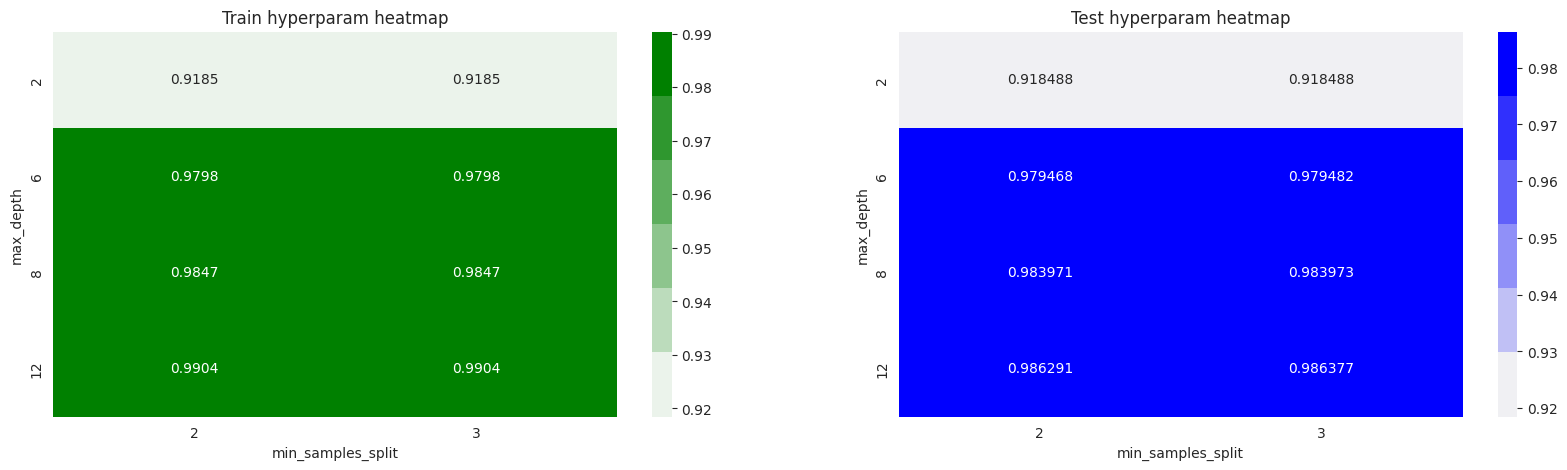

In [145]:
dt2 = dt_clf_tuni_2.best_estimator_
param = {#'entropy']
        'max_depth' : [2,6,8,12]
        ,'min_samples_split': [2,3]
        #,'min_samples_leaf': [1]
         }
result_visualization("DT_tuni_2", dt_clf_tuni_2,param,param1='max_depth',param2='min_samples_split')

In [147]:
dt3 = dt_clf_tuni_2.best_estimator_
param = {#criterion='gini''entropy'],
        'min_samples_leaf': [2,4,8]
         }
dt_clf_tuni_3 = hyperparam_tuning(dt3, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END min_samples_leaf=2; accuracy: (train=0.946, test=0.943) auc: (train=0.991, test=0.985) f1: (train=0.962, test=0.959) precision: (train=0.939, test=0.935) recall: (train=0.986, test=0.984) total time=   1.3s
[CV 2/10] END min_samples_leaf=2; accuracy: (train=0.944, test=0.939) auc: (train=0.990, test=0.986) f1: (train=0.960, test=0.957) precision: (train=0.936, test=0.934) recall: (train=0.985, test=0.981) total time=   1.3s
[CV 3/10] END min_samples_leaf=2; accuracy: (train=0.945, test=0.943) auc: (train=0.990, test=0.987) f1: (train=0.960, test=0.959) precision: (train=0.947, test=0.944) recall: (train=0.973, test=0.974) total time=   1.3s
[CV 4/10] END min_samples_leaf=2; accuracy: (train=0.946, test=0.942) auc: (train=0.991, test=0.987) f1: (train=0.961, test=0.959) precision: (train=0.940, test=0.935) recall: (train=0.984, test=0.983) total time=   1.3s
[CV 5/10] END min_samples_leaf=2; accuracy: (train=0.94

Best Score: 0.9868585150308118
Best Parameters: {'min_samples_leaf': 8}


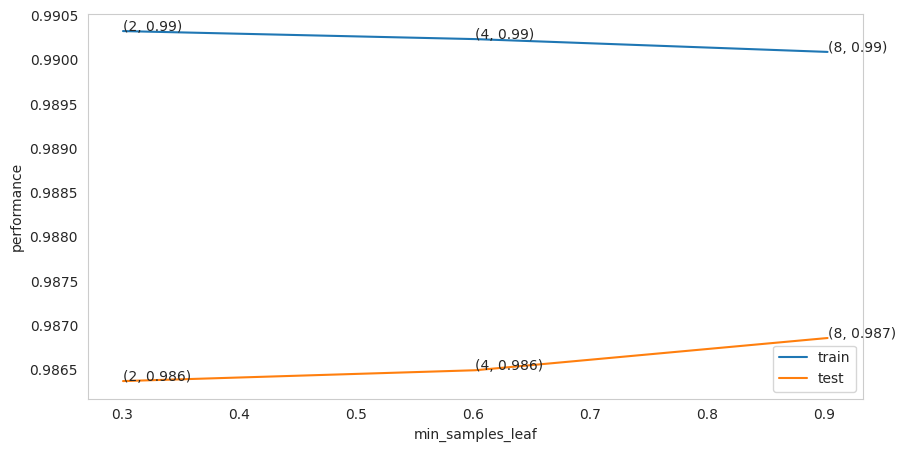

In [148]:
result_visualization("DT3",dt_clf_tuni_3, param, 'min_samples_leaf')

In [149]:
param = {#criterion='gini''entropy'],
        'min_samples_leaf': [6,10,14]
         }
dt_clf_tuni_3 = hyperparam_tuning(dt3, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END min_samples_leaf=6; accuracy: (train=0.946, test=0.943) auc: (train=0.991, test=0.986) f1: (train=0.961, test=0.960) precision: (train=0.938, test=0.935) recall: (train=0.985, test=0.985) total time=   1.3s
[CV 2/10] END min_samples_leaf=6; accuracy: (train=0.944, test=0.940) auc: (train=0.989, test=0.986) f1: (train=0.960, test=0.957) precision: (train=0.935, test=0.933) recall: (train=0.985, test=0.982) total time=   1.4s
[CV 3/10] END min_samples_leaf=6; accuracy: (train=0.945, test=0.943) auc: (train=0.990, test=0.987) f1: (train=0.960, test=0.959) precision: (train=0.947, test=0.944) recall: (train=0.973, test=0.974) total time=   1.3s
[CV 4/10] END min_samples_leaf=6; accuracy: (train=0.946, test=0.942) auc: (train=0.990, test=0.988) f1: (train=0.961, test=0.958) precision: (train=0.940, test=0.935) recall: (train=0.983, test=0.982) total time=   1.4s
[CV 5/10] END min_samples_leaf=6; accuracy: (train=0.94

Best Score: 0.9870530305382449
Best Parameters: {'min_samples_leaf': 14}


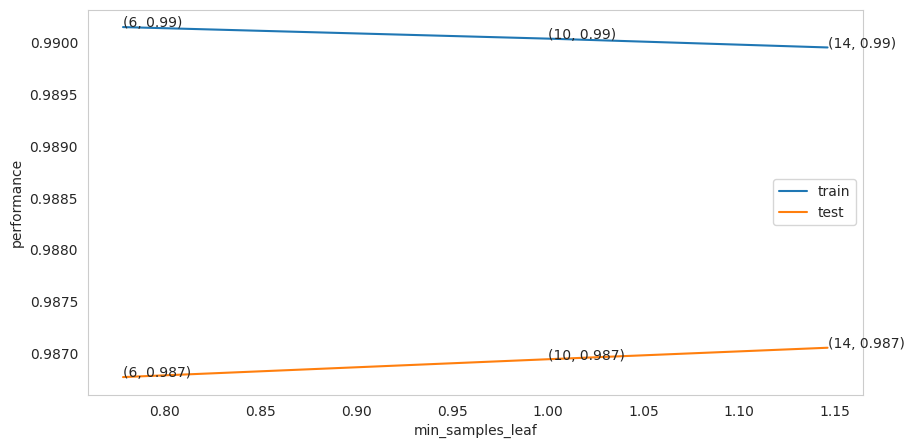

In [150]:
result_visualization("DT3",dt_clf_tuni_3, param, 'min_samples_leaf')

In [151]:
param = {#criterion='gini''entropy'],
        'min_samples_leaf': [20,30,40]
         }
dt_clf_tuni_3 = hyperparam_tuning(dt3, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END min_samples_leaf=20; accuracy: (train=0.945, test=0.942) auc: (train=0.990, test=0.987) f1: (train=0.960, test=0.959) precision: (train=0.937, test=0.935) recall: (train=0.984, test=0.984) total time=   1.3s
[CV 2/10] END min_samples_leaf=20; accuracy: (train=0.943, test=0.940) auc: (train=0.989, test=0.987) f1: (train=0.959, test=0.957) precision: (train=0.935, test=0.934) recall: (train=0.985, test=0.982) total time=   1.3s
[CV 3/10] END min_samples_leaf=20; accuracy: (train=0.944, test=0.943) auc: (train=0.990, test=0.987) f1: (train=0.959, test=0.959) precision: (train=0.946, test=0.944) recall: (train=0.973, test=0.973) total time=   1.3s
[CV 4/10] END min_samples_leaf=20; accuracy: (train=0.945, test=0.941) auc: (train=0.990, test=0.988) f1: (train=0.961, test=0.958) precision: (train=0.939, test=0.935) recall: (train=0.983, test=0.982) total time=   1.3s
[CV 5/10] END min_samples_leaf=20; accuracy: (train

Best Score: 0.987414545672651
Best Parameters: {'min_samples_leaf': 30}


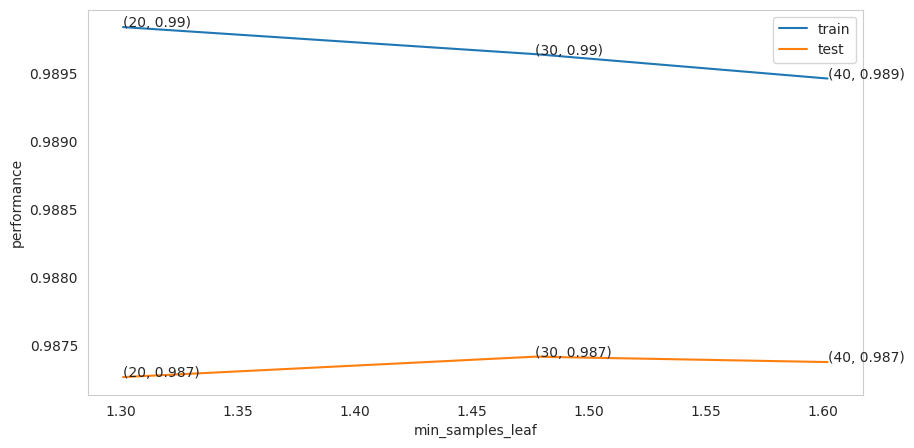

In [152]:
result_visualization("DT3",dt_clf_tuni_3, param, 'min_samples_leaf')

In [153]:
dt_clf_tuni_3.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=30,
                       min_samples_split=3)

In [73]:
best_dt_clf = DecisionTreeClassifier(criterion='entropy'
                      , max_depth=12
                      , min_samples_leaf=30,
                       min_samples_split=3)

In [154]:
pickle.dump(dt_clf_tuni_3, open(path+'models/dt_clf.pkl', 'wb'))

In [160]:
del evaluate_result

+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset | Model |        AUC         |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  |   DT  | 0.9229560718856326 | 0.9604737075919474 | 0.983798347503293  | 0.9382294497864468 | 0.9449070377552184 |
|   Test  |   DT  | 0.9214718079280185 | 0.9595955466524945 | 0.9826407300940526 | 0.937606518960375  | 0.9436343934756573 |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+


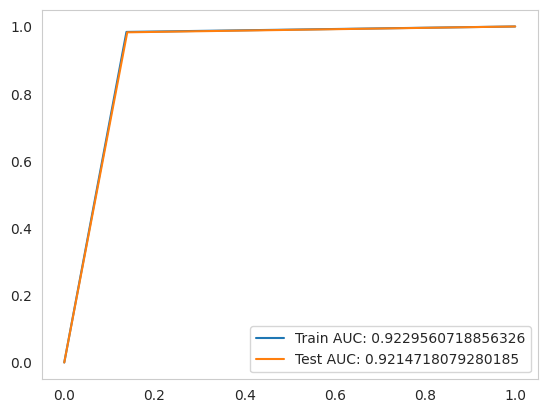

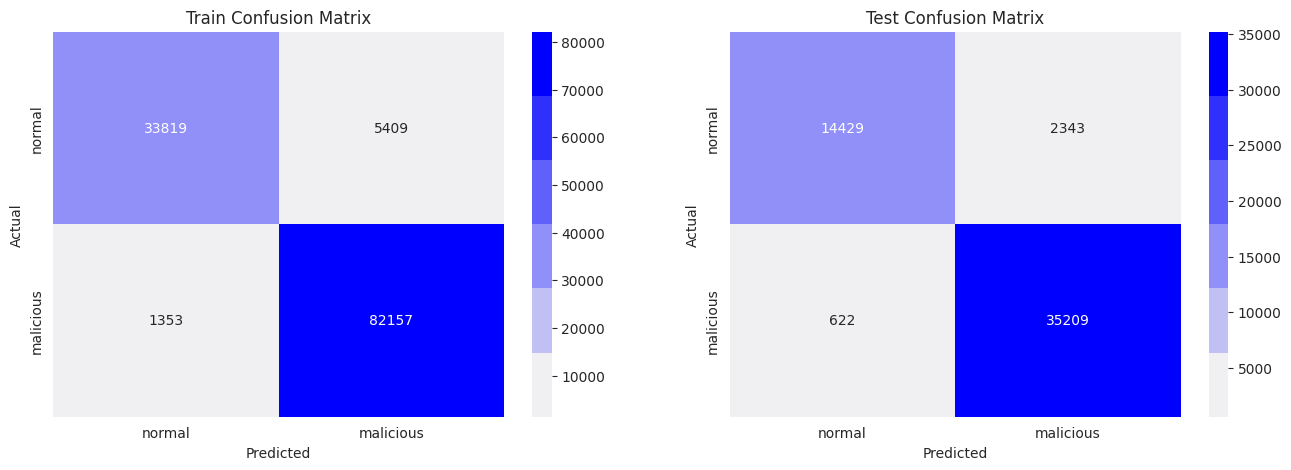

(DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=30,
                        min_samples_split=3),
 0.9214718079280185,
 0.9595955466524945,
 0.9826407300940526,
 0.937606518960375,
 0.9436343934756573,
 {'Model': ['RF', 'XGB', 'LR', 'SVM', 'DT'],
  'AUC': [0.9393536854780613,
   0.9464894309703068,
   0.9037510449240862,
   0.9015849509312749,
   0.9214718079280185],
  'F1-score': [0.9669216797842478,
   0.9684003272278532,
   0.9536448799397007,
   0.9535120916874681,
   0.9595955466524945],
  'Recall': [0.980603388127599,
   0.9746029974044822,
   0.9886969384052915,
   0.9914599090173314,
   0.9826407300940526],
  'Precision': [0.9536165015605916,
   0.96227610912097,
   0.9209931106200442,
   0.9183620711940645,
   0.937606518960375],
  'Accuracy': [0.9542991844571602,
   0.956675474782807,
   0.9345284489477786,
   0.9341482424956752,
   0.9436343934756573]})

In [74]:
evaluate_result('DT', best_dt_clf, X_train, y_train, X_test, y_test)

**Random Forest**

In [16]:
df= RandomForestClassifier()

In [163]:



param={
#'bootstrap':[True],
#'max_depth': [80, 90, 100, 110],
#'max_features': [2, 3],
#'min_samples_leaf':[3, 4, 5],
#'min_samples_split':[8, 10, 12],
'n_estimators':[100, 200, 300, 400]
}

df_clf = hyperparam_tuning(df, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END n_estimators=100; accuracy: (train=0.997, test=0.951) auc: (train=1.000, test=0.991) f1: (train=0.998, test=0.965) precision: (train=0.997, test=0.952) recall: (train=0.999, test=0.978) total time=  15.8s
[CV 2/10] END n_estimators=100; accuracy: (train=0.997, test=0.952) auc: (train=1.000, test=0.991) f1: (train=0.998, test=0.965) precision: (train=0.997, test=0.954) recall: (train=0.999, test=0.976) total time=  15.6s
[CV 3/10] END n_estimators=100; accuracy: (train=0.997, test=0.953) auc: (train=1.000, test=0.992) f1: (train=0.998, test=0.966) precision: (train=0.997, test=0.954) recall: (train=0.999, test=0.978) total time=  15.3s
[CV 4/10] END n_estimators=100; accuracy: (train=0.997, test=0.949) auc: (train=1.000, test=0.991) f1: (train=0.998, test=0.963) precision: (train=0.997, test=0.951) recall: (train=0.999, test=0.976) total time=  15.7s
[CV 5/10] END n_estimators=100; accuracy: (train=0.997, test=0.

Best Score: 0.9919453288443865
Best Parameters: {'n_estimators': 300}


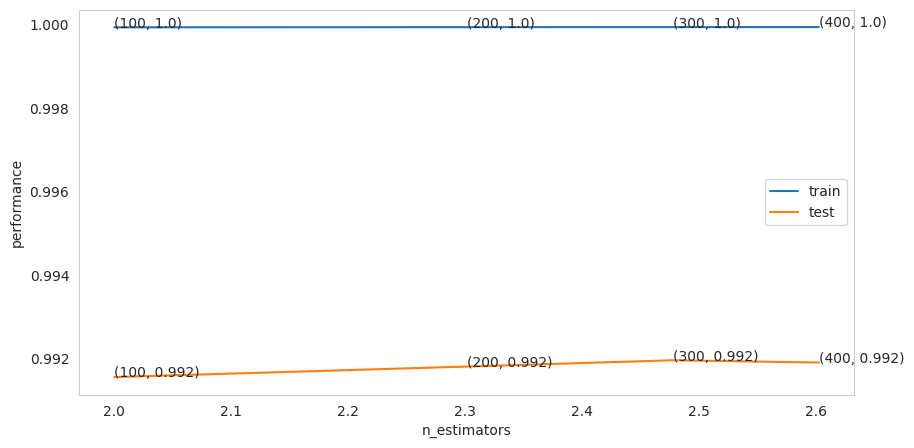

In [164]:
result_visualization('df', df_clf, param, param1='n_estimators')

In [165]:
param={
#'bootstrap':[True],
'max_depth': [10, 15, 20, 30],
#'max_features': [2, 3],
#'min_samples_leaf':[3, 4, 5],
#'min_samples_split':[8, 10, 12],
#'n_estimators':[100, 200, 300, 400]
}

df_clf_2 = hyperparam_tuning(df, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END max_depth=10; accuracy: (train=0.935, test=0.934) auc: (train=0.989, test=0.987) f1: (train=0.954, test=0.954) precision: (train=0.912, test=0.912) recall: (train=1.000, test=1.000) total time=  10.1s
[CV 2/10] END max_depth=10; accuracy: (train=0.934, test=0.935) auc: (train=0.989, test=0.988) f1: (train=0.954, test=0.955) precision: (train=0.912, test=0.913) recall: (train=1.000, test=1.000) total time=  10.1s
[CV 3/10] END max_depth=10; accuracy: (train=0.935, test=0.934) auc: (train=0.989, test=0.988) f1: (train=0.955, test=0.953) precision: (train=0.913, test=0.911) recall: (train=1.000, test=1.000) total time=   9.9s
[CV 4/10] END max_depth=10; accuracy: (train=0.935, test=0.931) auc: (train=0.989, test=0.987) f1: (train=0.955, test=0.951) precision: (train=0.913, test=0.907) recall: (train=1.000, test=1.000) total time=  10.4s
[CV 5/10] END max_depth=10; accuracy: (train=0.935, test=0.936) auc: (train=0.9

Best Score: 0.9919728648441513
Best Parameters: {'max_depth': 30}


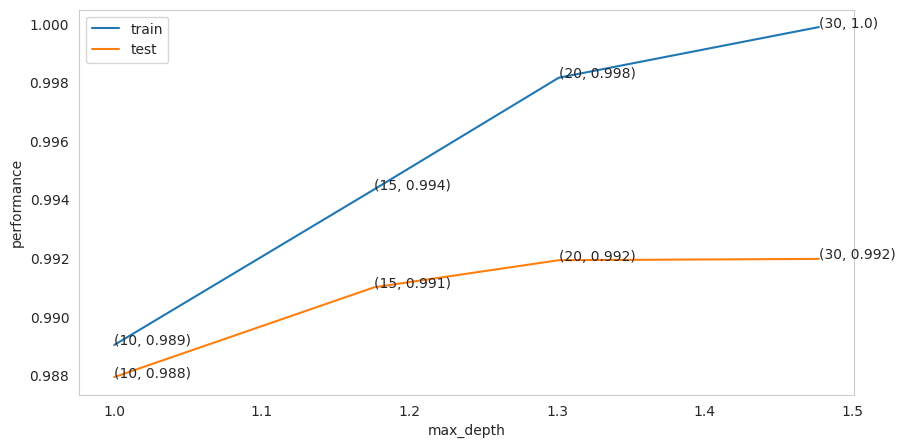

In [167]:
result_visualization('df', df_clf_2, param, param1='max_depth')

In [17]:
param={
#'bootstrap':[True],
#'max_depth': [30], #30
#'max_features': [2, 3],
#'min_samples_leaf':[3, 4, 5],
'min_samples_split':[6, 10, 12] #12
#'n_estimators':[100, 200, 300, 400]# 300
}

df_clf_3 = hyperparam_tuning(df, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END min_samples_split=6; accuracy: (train=0.992, test=0.951) auc: (train=1.000, test=0.992) f1: (train=0.994, test=0.964) precision: (train=0.991, test=0.950) recall: (train=0.998, test=0.979) total time=  15.2s
[CV 2/10] END min_samples_split=6; accuracy: (train=0.992, test=0.953) auc: (train=1.000, test=0.992) f1: (train=0.994, test=0.966) precision: (train=0.990, test=0.953) recall: (train=0.998, test=0.980) total time=  15.5s
[CV 3/10] END min_samples_split=6; accuracy: (train=0.992, test=0.953) auc: (train=1.000, test=0.993) f1: (train=0.994, test=0.966) precision: (train=0.990, test=0.952) recall: (train=0.998, test=0.981) total time=  15.2s
[CV 4/10] END min_samples_split=6; accuracy: (train=0.992, test=0.949) auc: (train=1.000, test=0.992) f1: (train=0.994, test=0.963) precision: (train=0.990, test=0.947) recall: (train=0.998, test=0.979) total time=  15.2s
[CV 5/10] END min_samples_split=6; accuracy: (train

Best Score: 0.992115685620667
Best Parameters: {'min_samples_split': 12}


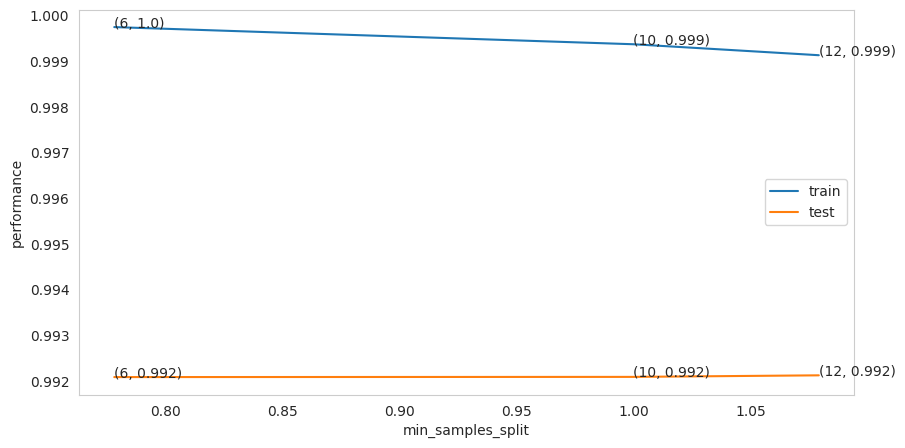

In [18]:
result_visualization('df', df_clf_3, param, param1='min_samples_split')

In [20]:
param={
    'criterion':['gini','entropy'],
'max_depth': [30], #30
#'max_features': [2, 3],
#'min_samples_leaf':[3, 4, 5],
'min_samples_split':[12] #12
#'n_estimators':[100, 200, 300, 400]# 300
}

df_clf_4 = hyperparam_tuning(df, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END criterion=gini, max_depth=30, min_samples_split=12; accuracy: (train=0.982, test=0.953) auc: (train=0.999, test=0.992) f1: (train=0.987, test=0.966) precision: (train=0.978, test=0.950) recall: (train=0.996, test=0.982) total time=  15.1s
[CV 2/10] END criterion=gini, max_depth=30, min_samples_split=12; accuracy: (train=0.981, test=0.953) auc: (train=0.999, test=0.992) f1: (train=0.986, test=0.966) precision: (train=0.977, test=0.952) recall: (train=0.996, test=0.980) total time=  15.3s
[CV 3/10] END criterion=gini, max_depth=30, min_samples_split=12; accuracy: (train=0.981, test=0.953) auc: (train=0.999, test=0.992) f1: (train=0.986, test=0.966) precision: (train=0.977, test=0.949) recall: (train=0.996, test=0.983) total time=  14.8s
[CV 4/10] END criterion=gini, max_depth=30, min_samples_split=12; accuracy: (train=0.982, test=0.950) auc: (train=0.999, test=0.992) f1: (train=0.987, test=0.964) precision: (train

Best Score: 0.9921120268709119
Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 12}


TypeError: ignored

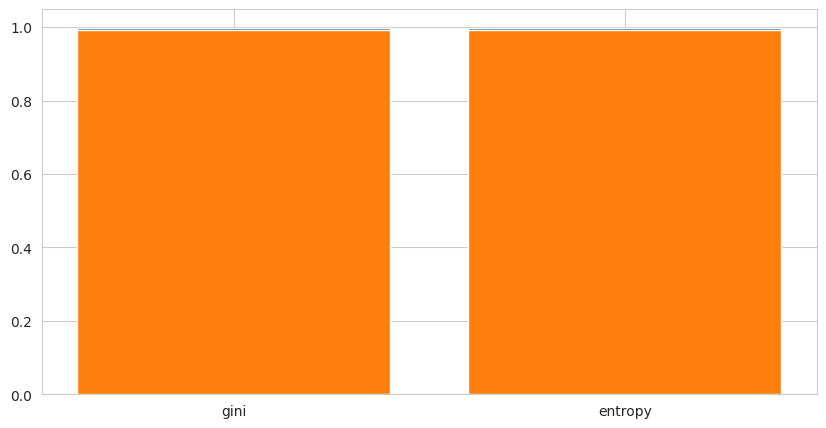

In [27]:
result_visualization('df', df_clf_4, param, param1='criterion')

In [29]:
param={
#'criterion':['gini','entropy'],
#'max_depth': [30], #30
'max_features': [10, 13,15],
#'min_samples_leaf':[3, 4, 5],
#'min_samples_split':[12] #12
#'n_estimators':[100, 200, 300, 400]# 300
}

df_clf_5 = hyperparam_tuning(df, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END max_features=10; accuracy: (train=0.997, test=0.949) auc: (train=1.000, test=0.991) f1: (train=0.998, test=0.963) precision: (train=0.997, test=0.950) recall: (train=0.999, test=0.976) total time=  14.8s
[CV 2/10] END max_features=10; accuracy: (train=0.997, test=0.951) auc: (train=1.000, test=0.991) f1: (train=0.998, test=0.965) precision: (train=0.997, test=0.954) recall: (train=0.999, test=0.976) total time=  14.4s
[CV 3/10] END max_features=10; accuracy: (train=0.997, test=0.952) auc: (train=1.000, test=0.992) f1: (train=0.998, test=0.965) precision: (train=0.997, test=0.954) recall: (train=0.999, test=0.977) total time=  14.8s
[CV 4/10] END max_features=10; accuracy: (train=0.997, test=0.950) auc: (train=1.000, test=0.991) f1: (train=0.998, test=0.964) precision: (train=0.997, test=0.950) recall: (train=0.999, test=0.978) total time=  14.0s
[CV 5/10] END max_features=10; accuracy: (train=0.997, test=0.951) 

In [25]:
X_train.shape

(122738, 175)

Best Score: 0.9915977905335511
Best Parameters: {'max_features': 15}


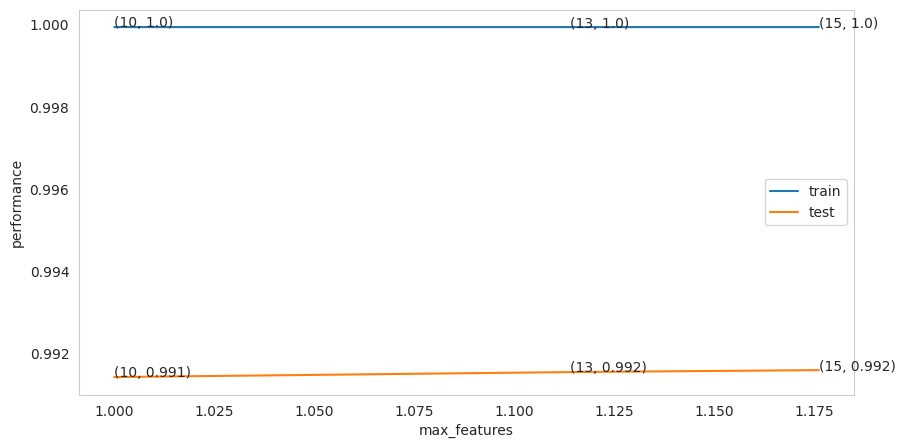

In [30]:
result_visualization('df', df_clf_5, param, param1='max_features')

In [31]:
rf_clf_best = RandomForestClassifier(criterion='gini', max_depth=30, min_samples_split=12, n_estimators=300, max_features = 15)

+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset | Model |        AUC         |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  |   RF  | 0.9757430094025078 | 0.9875648776084659 | 0.9956891390252665 | 0.9795721219546676 | 0.9829392690120419 |
|   Test  |   RF  | 0.9393536854780613 | 0.9669216797842478 | 0.980603388127599  | 0.9536165015605916 | 0.9542991844571602 |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+


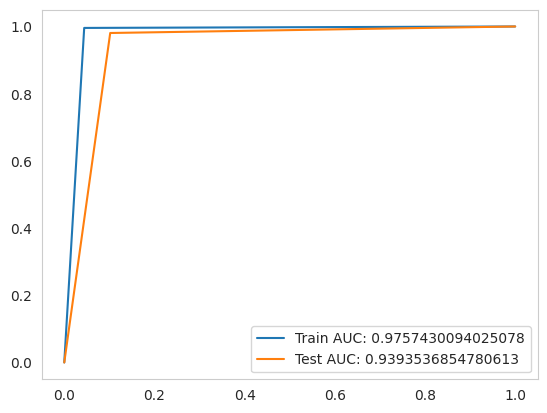

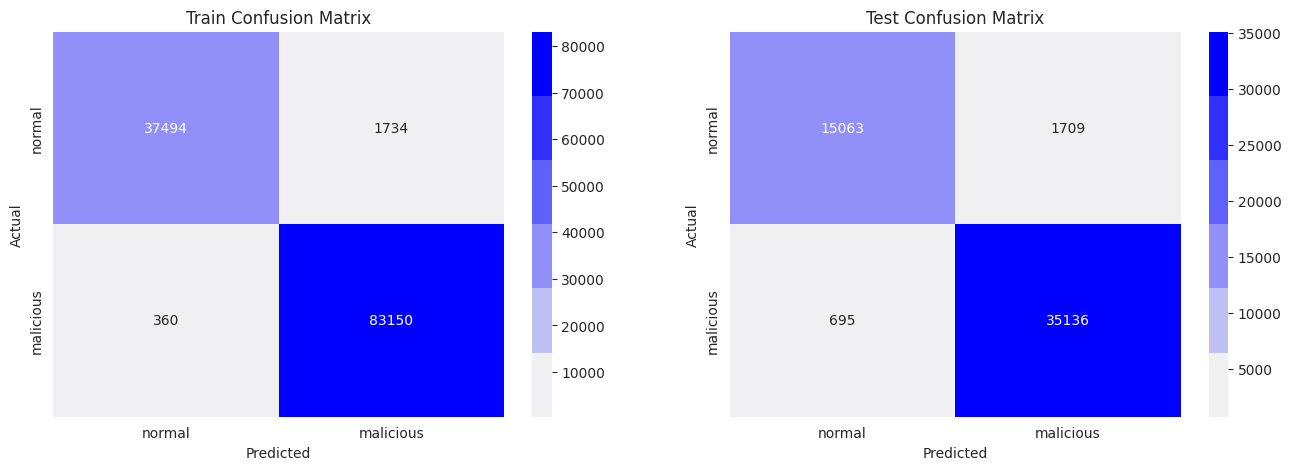

(RandomForestClassifier(max_depth=30, max_features=15, min_samples_split=12,
                        n_estimators=300),
 0.9393536854780613,
 0.9669216797842478,
 0.980603388127599,
 0.9536165015605916,
 0.9542991844571602,
 {'Model': ['RF'],
  'AUC': [0.9393536854780613],
  'F1-score': [0.9669216797842478],
  'Recall': [0.980603388127599],
  'Precision': [0.9536165015605916],
  'Accuracy': [0.9542991844571602]})

In [33]:
evaluate_result('RF', rf_clf_best, X_train, y_train, X_test, y_test)

In [34]:
pickle.dump(rf_clf_best, open(path+'models/rf_clf.pkl', 'wb'))

**XGB**

In [46]:
xgbs = xgb.XGBClassifier()

In [47]:
param = {'learning_rate':[0.001, 0.01, 0.1]}

xgb_clf = hyperparam_tuning(xgbs, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END learning_rate=0.001; accuracy: (train=0.940, test=0.942) auc: (train=0.983, test=0.983) f1: (train=0.957, test=0.958) precision: (train=0.930, test=0.930) recall: (train=0.986, test=0.988) total time=  42.3s
[CV 2/10] END learning_rate=0.001; accuracy: (train=0.937, test=0.936) auc: (train=0.983, test=0.983) f1: (train=0.955, test=0.955) precision: (train=0.918, test=0.918) recall: (train=0.996, test=0.995) total time=  40.7s
[CV 3/10] END learning_rate=0.001; accuracy: (train=0.938, test=0.935) auc: (train=0.983, test=0.982) f1: (train=0.956, test=0.954) precision: (train=0.920, test=0.917) recall: (train=0.996, test=0.994) total time=  41.3s
[CV 4/10] END learning_rate=0.001; accuracy: (train=0.938, test=0.934) auc: (train=0.983, test=0.982) f1: (train=0.956, test=0.954) precision: (train=0.919, test=0.915) recall: (train=0.996, test=0.996) total time=  40.5s
[CV 5/10] END learning_rate=0.001; accuracy: (train

Best Score: 0.9911132134772085
Best Parameters: {'learning_rate': 0.1}


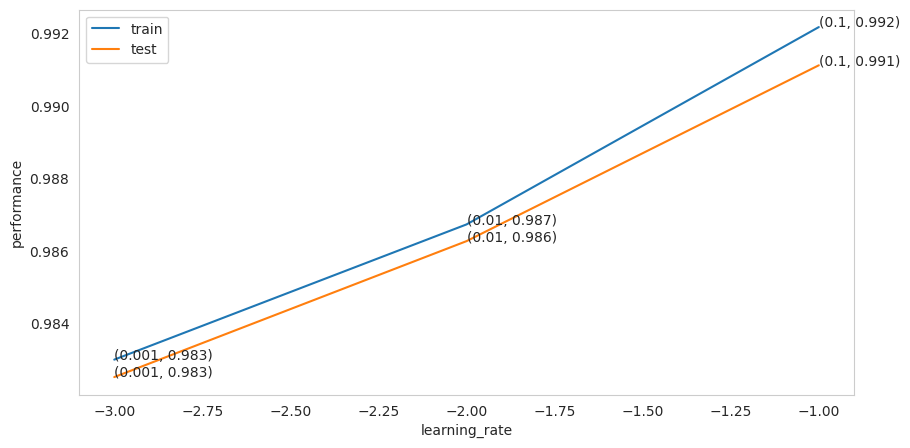

In [48]:
result_visualization('xgbs', xgb_clf, param, param1='learning_rate')

In [49]:
X_train.shape

(122738, 175)

In [50]:
param = {'max_depth':[3, 5, 8]} #'learning_rate': 0.1
xgb_clf2 = hyperparam_tuning(xgbs, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END max_depth=3; accuracy: (train=0.950, test=0.948) auc: (train=0.992, test=0.991) f1: (train=0.964, test=0.962) precision: (train=0.949, test=0.947) recall: (train=0.979, test=0.977) total time=  22.1s
[CV 2/10] END max_depth=3; accuracy: (train=0.950, test=0.946) auc: (train=0.992, test=0.991) f1: (train=0.964, test=0.961) precision: (train=0.949, test=0.948) recall: (train=0.979, test=0.975) total time=  19.4s
[CV 3/10] END max_depth=3; accuracy: (train=0.949, test=0.947) auc: (train=0.991, test=0.991) f1: (train=0.963, test=0.962) precision: (train=0.948, test=0.945) recall: (train=0.980, test=0.979) total time=  22.1s
[CV 4/10] END max_depth=3; accuracy: (train=0.950, test=0.946) auc: (train=0.992, test=0.990) f1: (train=0.964, test=0.961) precision: (train=0.949, test=0.945) recall: (train=0.979, test=0.978) total time=  19.5s
[CV 5/10] END max_depth=3; accuracy: (train=0.950, test=0.949) auc: (train=0.992, t

Best Score: 0.9928465420417606
Best Parameters: {'max_depth': 8}


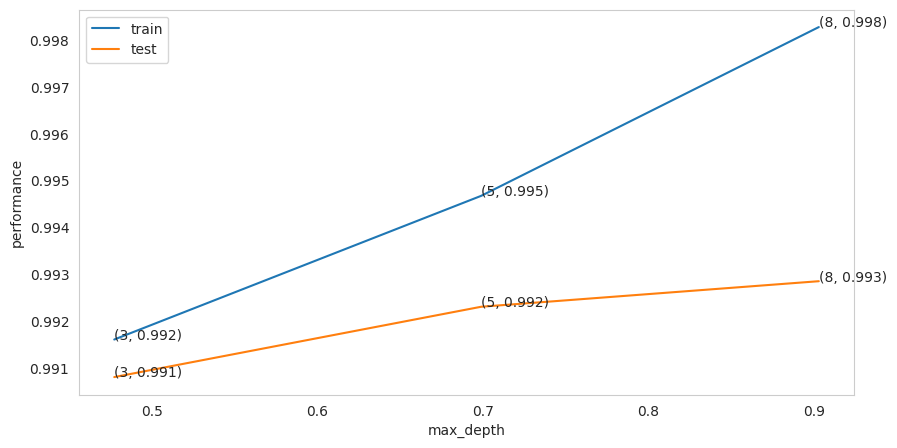

In [51]:
result_visualization('xgbs', xgb_clf2, param, param1='max_depth')

In [52]:
param = {'max_depth':[8, 20, 30]} #'learning_rate': 0.1
xgb_clf2 = hyperparam_tuning(xgbs, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END max_depth=8; accuracy: (train=0.981, test=0.954) auc: (train=0.998, test=0.992) f1: (train=0.986, test=0.966) precision: (train=0.980, test=0.958) recall: (train=0.992, test=0.975) total time=  51.3s
[CV 2/10] END max_depth=8; accuracy: (train=0.979, test=0.957) auc: (train=0.998, test=0.993) f1: (train=0.985, test=0.968) precision: (train=0.978, test=0.961) recall: (train=0.991, test=0.976) total time=  52.8s
[CV 3/10] END max_depth=8; accuracy: (train=0.980, test=0.957) auc: (train=0.998, test=0.993) f1: (train=0.985, test=0.968) precision: (train=0.978, test=0.960) recall: (train=0.992, test=0.977) total time=  52.2s
[CV 4/10] END max_depth=8; accuracy: (train=0.980, test=0.954) auc: (train=0.998, test=0.993) f1: (train=0.986, test=0.966) precision: (train=0.980, test=0.955) recall: (train=0.992, test=0.978) total time=  51.5s
[CV 5/10] END max_depth=8; accuracy: (train=0.980, test=0.955) auc: (train=0.998, t

Best Score: 0.9928794827995766
Best Parameters: {'max_depth': 20}


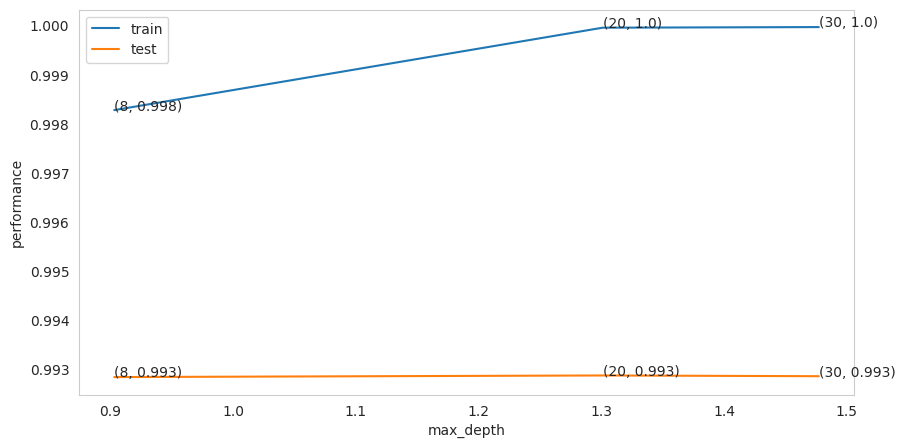

In [53]:
result_visualization('xgbs', xgb_clf2, param, param1='max_depth')

In [54]:
param = {'colsample_bylevel':[0.1, 0.5, 1]} #'learning_rate': 0.1, 'max_depth'=20
xgb_clf3 = hyperparam_tuning(xgbs, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END colsample_bylevel=0.1; accuracy: (train=0.959, test=0.950) auc: (train=0.994, test=0.991) f1: (train=0.970, test=0.964) precision: (train=0.959, test=0.952) recall: (train=0.982, test=0.976) total time=   8.9s
[CV 2/10] END colsample_bylevel=0.1; accuracy: (train=0.961, test=0.953) auc: (train=0.994, test=0.992) f1: (train=0.971, test=0.966) precision: (train=0.960, test=0.956) recall: (train=0.983, test=0.976) total time=   9.1s
[CV 3/10] END colsample_bylevel=0.1; accuracy: (train=0.959, test=0.951) auc: (train=0.994, test=0.992) f1: (train=0.970, test=0.965) precision: (train=0.958, test=0.951) recall: (train=0.983, test=0.979) total time=   6.9s
[CV 4/10] END colsample_bylevel=0.1; accuracy: (train=0.959, test=0.950) auc: (train=0.994, test=0.991) f1: (train=0.970, test=0.963) precision: (train=0.958, test=0.950) recall: (train=0.982, test=0.978) total time=   8.4s
[CV 5/10] END colsample_bylevel=0.1; accura

In [56]:
param = {'subsample':[0.1, 0.4, 0.7, 1.0]} #'learning_rate': 0.1, 'max_depth'=20, 'colsample_bylevel'=0.5
xgb_clf4 = hyperparam_tuning(xgbs, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END subsample=0.1; accuracy: (train=0.955, test=0.942) auc: (train=0.993, test=0.988) f1: (train=0.967, test=0.957) precision: (train=0.961, test=0.951) recall: (train=0.974, test=0.964) total time=  25.2s
[CV 2/10] END subsample=0.1; accuracy: (train=0.955, test=0.946) auc: (train=0.992, test=0.989) f1: (train=0.967, test=0.961) precision: (train=0.961, test=0.955) recall: (train=0.973, test=0.967) total time=  24.3s
[CV 3/10] END subsample=0.1; accuracy: (train=0.955, test=0.944) auc: (train=0.993, test=0.989) f1: (train=0.967, test=0.959) precision: (train=0.961, test=0.953) recall: (train=0.973, test=0.965) total time=  23.5s
[CV 4/10] END subsample=0.1; accuracy: (train=0.956, test=0.942) auc: (train=0.993, test=0.988) f1: (train=0.968, test=0.957) precision: (train=0.962, test=0.947) recall: (train=0.973, test=0.968) total time=  25.0s
[CV 5/10] END subsample=0.1; accuracy: (train=0.956, test=0.945) auc: (trai

Best Score: 0.9924245289288145
Best Parameters: {'subsample': 1.0}


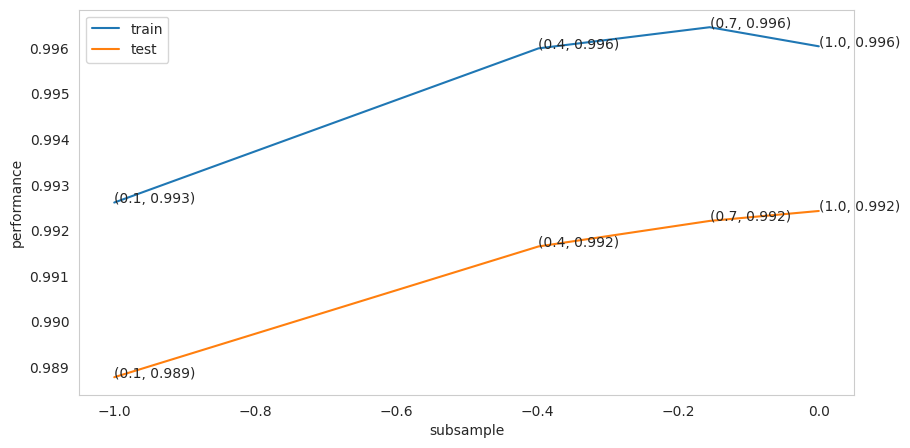

In [57]:
param = {'subsample':[0.1, 0.4, 0.7, 1.0]} #'learning_rate': 0.1, 'max_depth'=20, 'colsample_bylevel'=0.5
result_visualization('xgbs', xgb_clf4, param, param1='subsample')

In [58]:
param = {'n_estimators':[100, 200, 300, 400]}
xgb_clf5 = hyperparam_tuning(xgbs, param, X_train, y_train, cv=10)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END n_estimators=100; accuracy: (train=0.967, test=0.952) auc: (train=0.996, test=0.992) f1: (train=0.976, test=0.965) precision: (train=0.968, test=0.956) recall: (train=0.984, test=0.975) total time=  37.8s
[CV 2/10] END n_estimators=100; accuracy: (train=0.967, test=0.953) auc: (train=0.996, test=0.993) f1: (train=0.976, test=0.966) precision: (train=0.968, test=0.958) recall: (train=0.985, test=0.973) total time=  38.7s
[CV 3/10] END n_estimators=100; accuracy: (train=0.967, test=0.954) auc: (train=0.996, test=0.993) f1: (train=0.976, test=0.967) precision: (train=0.967, test=0.955) recall: (train=0.985, test=0.978) total time=  39.6s
[CV 4/10] END n_estimators=100; accuracy: (train=0.968, test=0.953) auc: (train=0.996, test=0.992) f1: (train=0.977, test=0.966) precision: (train=0.968, test=0.954) recall: (train=0.986, test=0.978) total time=  38.2s
[CV 5/10] END n_estimators=100; accuracy: (train=0.968, test=0.

Best Score: 0.9926774635966448
Best Parameters: {'n_estimators': 300}


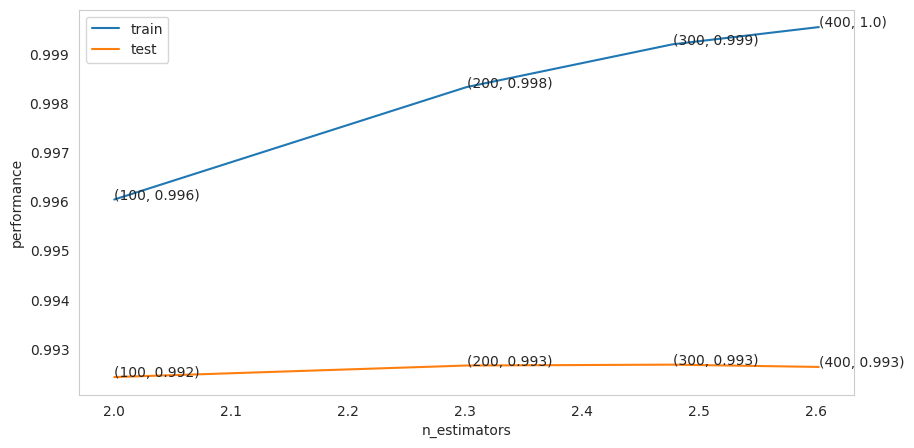

In [59]:
param = {'n_estimators':[100, 200, 300, 400]} #'learning_rate': 0.1, 'max_depth'=20, 'colsample_bylevel'=0.5, 'subsample': 1.0
result_visualization('xgbs', xgb_clf5, param, param1='n_estimators')

+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset | Model |        AUC         |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  |  XGB  | 0.9946508690655042 | 0.9971424813783044 | 0.9986827924799425 | 0.9956069143348295 | 0.9961055255910964 |
|   Test  |  XGB  | 0.9464894309703068 | 0.9684003272278532 | 0.9746029974044822 |  0.96227610912097  | 0.956675474782807  |
+---------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+


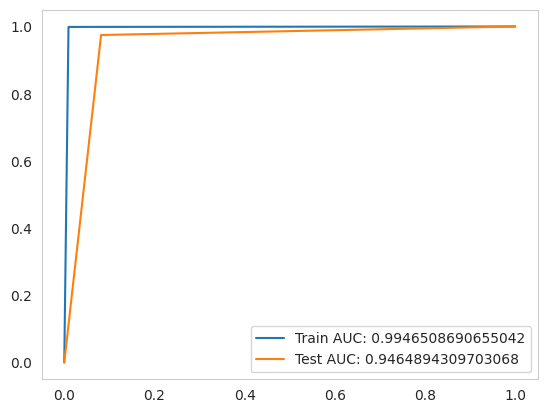

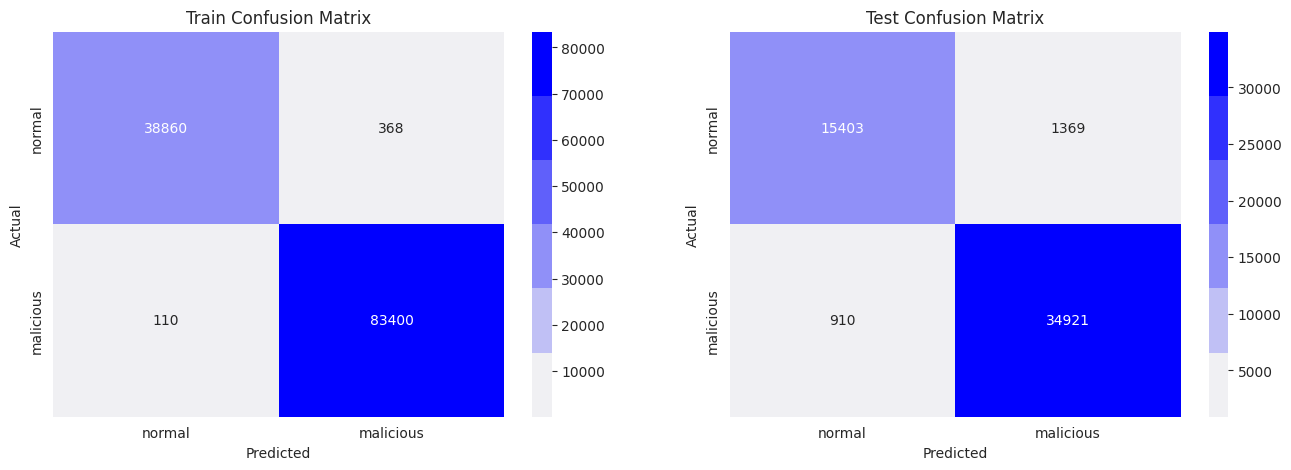

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.5, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=20, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=300, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 0.9464894309703068,
 0.9684003272278532,
 0.9746029974044822,
 0.96227610912097,
 0.956675474782807,
 {'Model': ['RF', 'XGB'],
  'AUC': [0.9393536854780613, 0.9464894309703068],
  'F1-score': [0.9669216797842478, 0.9684003272278532],
  'Re

In [61]:
best_params = {'n_estimators':300,
               'max_depth':20,
               'learning_rate':0.1,
               'colsample_bylevel':0.5,
               'subsample': 1.0}
xgb_bst_clf = xgb.XGBClassifier(**best_params)
evaluate_result('XGB', xgb_bst_clf, X_train, y_train, X_test, y_test)

In [63]:
pickle.dump(xgb_bst_clf, open(path+'models/xgb_clf.pkl', 'wb'))

In [76]:
pd.DataFrame(result_dict)

,Model,AUC,F1-score,Recall,Precision,Accuracy
0,RF,0.939354,0.966922,0.980603,0.953617,0.954299
1,XGB,0.946489,0.968400,0.974603,0.962276,0.956675
2,LR,0.903751,0.953645,0.988697,0.920993,0.934528
3,SVM,0.901585,0.953512,0.991460,0.918362,0.934148
4,DT,0.921472,0.959596,0.982641,0.937607,0.943634


In [77]:
np.count_nonzero(xgb_bst_clf.feature_importances_)

54

In [78]:
np.count_nonzero(best_dt_clf.feature_importances_)

34

In [79]:
np.count_nonzero(rf_clf_best.feature_importances_)

175

In [83]:
indices = np.argsort(-1 * abs(xgb_bst_clf.feature_importances_))[:54]
indices_r = np.argsort(-1 * abs(rf_clf_best.feature_importances_))[:175]
indices_d = np.argsort(-1 * abs(best_dt_clf.feature_importances_))[:34]

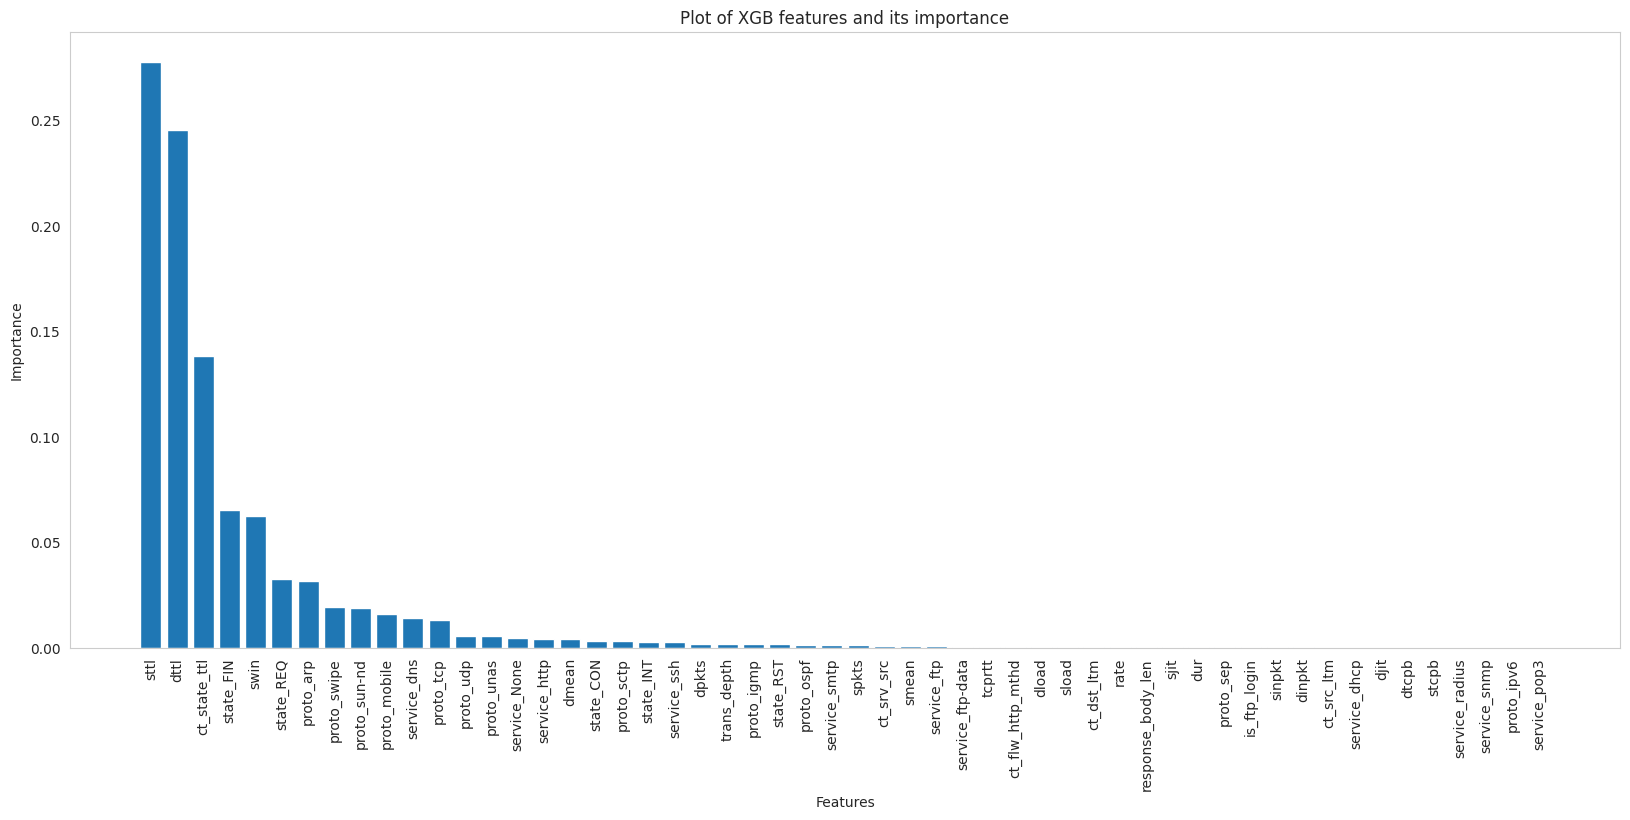

In [87]:
plt.figure(figsize=(20,8))
plt.bar(X_train.columns[indices], abs(xgb_bst_clf.feature_importances_[indices]))
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot of XGB features and its importance")
plt.grid()
plt.savefig(path+f"/pic/XGB_Features_importance.png")
plt.show()

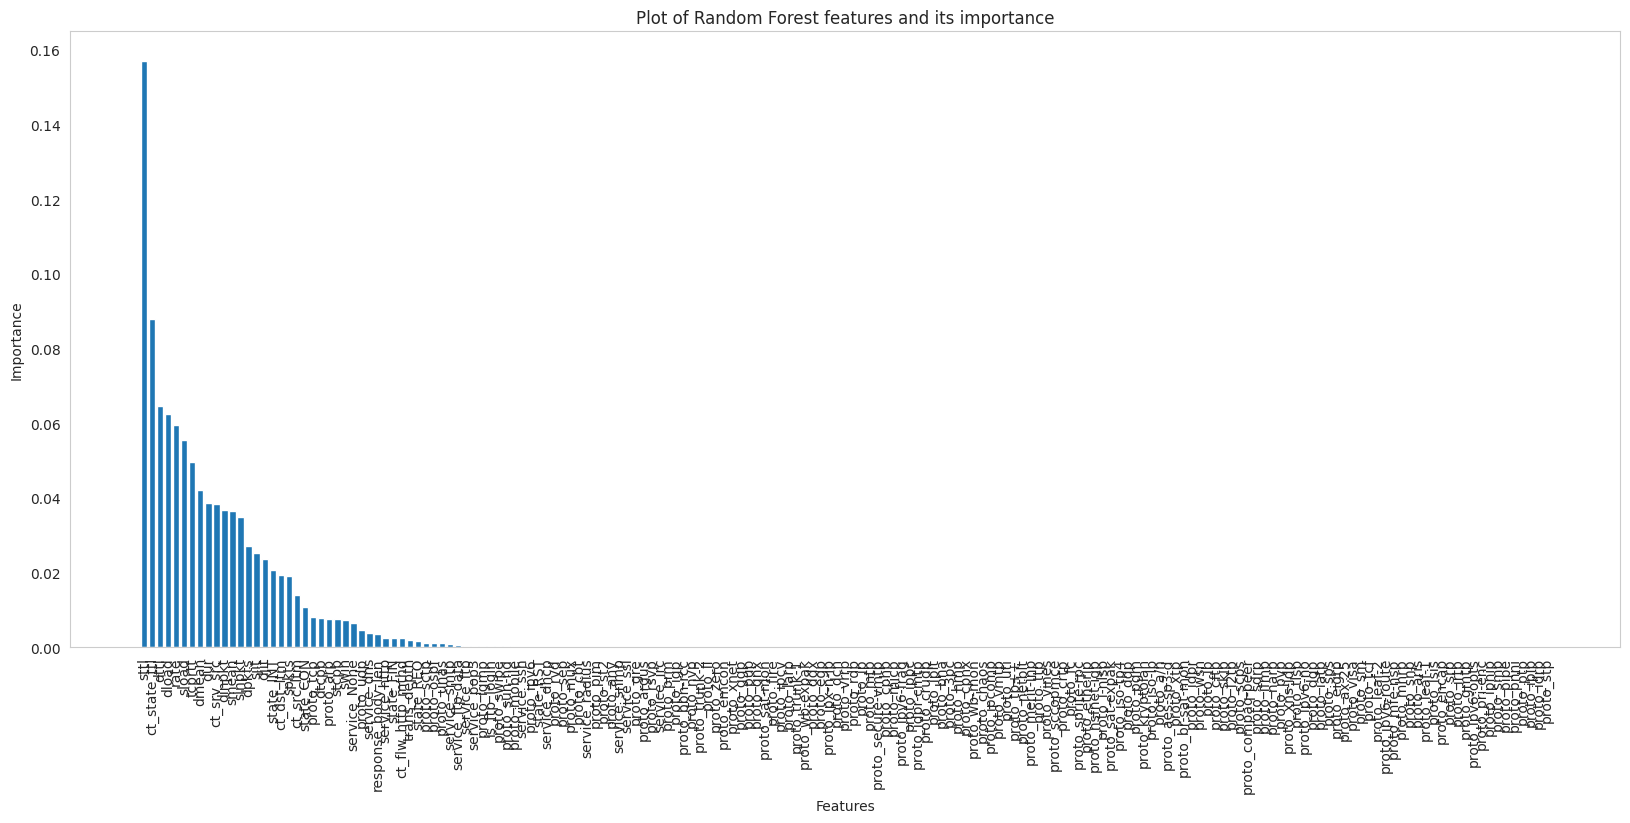

In [88]:
plt.figure(figsize=(20,8))
plt.bar(X_train.columns[indices_r], abs(rf_clf_best.feature_importances_[indices_r]))
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot of Random Forest features and its importance")
plt.grid()
plt.savefig(path+f"/pic/RF_Features_importance.png")
plt.show()

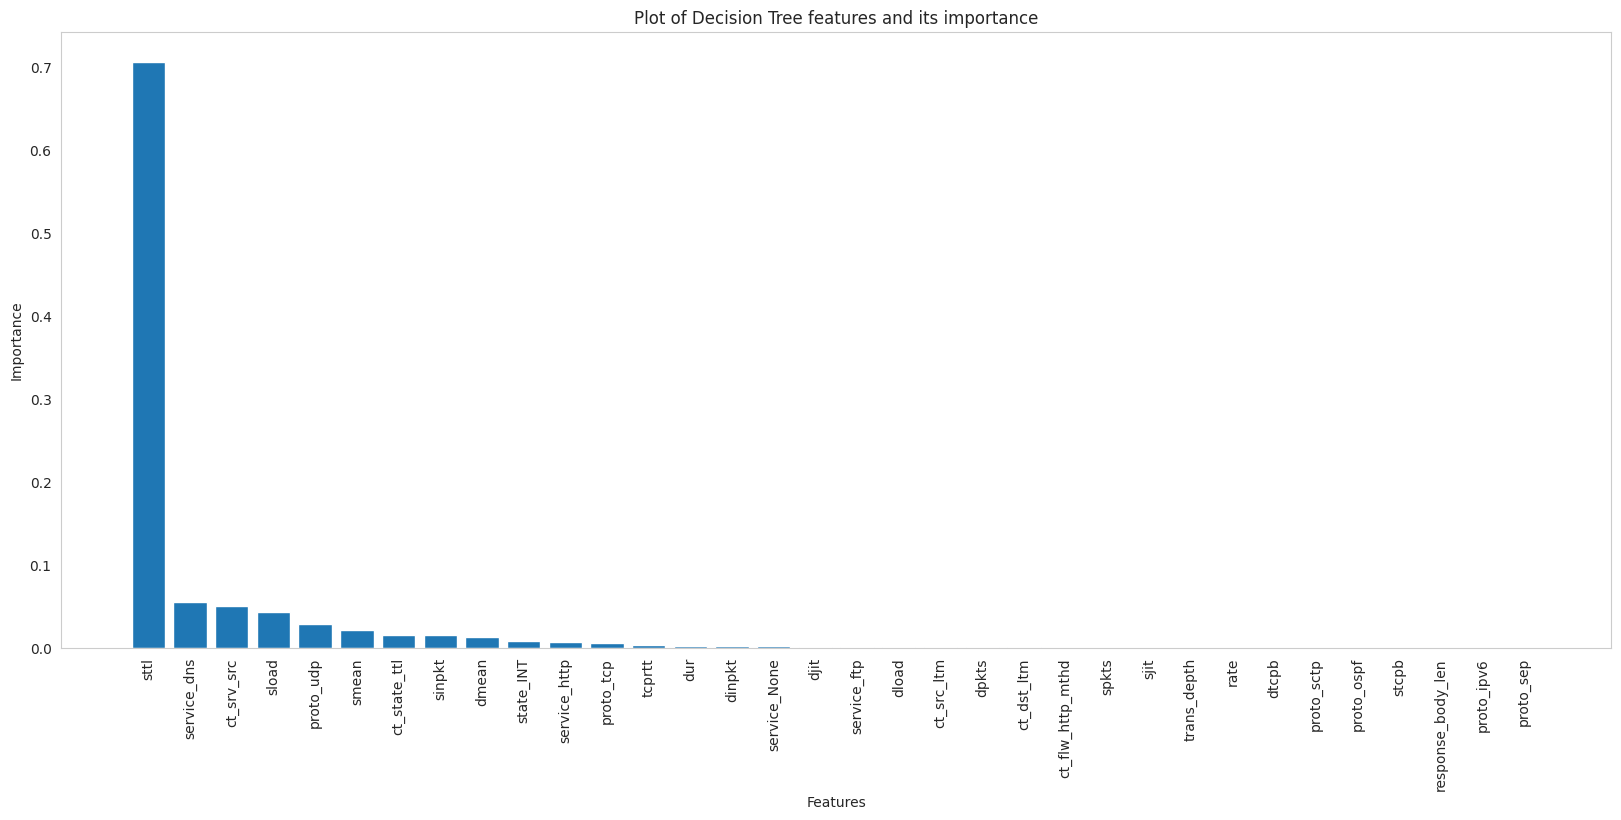

In [89]:
plt.figure(figsize=(20,8))
plt.bar(X_train.columns[indices_d], abs(best_dt_clf.feature_importances_[indices_d]))
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot of Decision Tree features and its importance")
plt.grid()
plt.savefig(path+f"/pic/DT_Features_importance.png")
plt.show()

**Voting**

In [90]:
# Initializing all the 3 classifiers with best found parameters
dt_clf = DecisionTreeClassifier(
                criterion='entropy'
                , max_depth=12
                , min_samples_leaf=30
                ,min_samples_split=3)
rf_clf = RandomForestClassifier(
                criterion='gini'
                , max_depth=30
                , min_samples_split=12
                , n_estimators=300
                , max_features = 15)
xgb_clf = xgb.XGBClassifier(
                n_estimators=300,
               max_depth=20,
               learning_rate=0.1,
               colsample_bylevel=0.5,
               subsample=1.0
)

In [107]:
pd.DataFrame(result_dict)

,Model,AUC,F1-score,Recall,Precision,Accuracy
0,RF,0.939354,0.966922,0.980603,0.953617,0.954299
1,XGB,0.946489,0.968400,0.974603,0.962276,0.956675
2,LR,0.903751,0.953645,0.988697,0.920993,0.934528
3,SVM,0.901585,0.953512,0.991460,0.918362,0.934148
4,DT,0.921472,0.959596,0.982641,0.937607,0.943634


In [124]:

vot = pd.DataFrame(result_dict).loc[pd.DataFrame(result_dict)['Model'].isin(['XGB', 'RF', 'DT'])]

In [125]:
vot

,Model,AUC,F1-score,Recall,Precision,Accuracy
0,RF,0.939354,0.966922,0.980603,0.953617,0.954299
1,XGB,0.946489,0.968400,0.974603,0.962276,0.956675
4,DT,0.921472,0.959596,0.982641,0.937607,0.943634


**Weights**

In [182]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
#vot[['AUC', 'F1-score', 'Recall', 'Precision', 'Accuracy']] = scaler.fit_transform(vot[['AUC', 'F1-score', 'Recall', 'Precision', 'Accuracy']])
vot['AUC'] = vot['AUC'] * 2

vot['total_score'] = vot[['AUC', 'F1-score', 'Recall', 'Precision', 'Accuracy']].sum(axis=1)

vot['weights'] = vot['total_score'] / vot['total_score'].sum()
weights = vot['weights'].tolist()
print(vot)


  Model       AUC  F1-score    Recall  Precision  Accuracy  total_score  \
0    RF  45.74536  0.832063  0.746528   0.648976  0.817784    48.790711   
1   XGB  64.00000  1.000000  0.000000   1.000000  1.000000    67.000000   
4    DT   0.00000  0.000000  1.000000   0.000000  0.000000     1.000000   

    weights  
0  0.417762  
1  0.573676  
4  0.008562  


+---------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset |   Model    |        AUC         |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  | Voting_auc | 0.9937916712928335 | 0.9967312254617816 | 0.9986468686384864 | 0.9948229175364722 | 0.995543352506966  |
|   Test  | Voting_auc | 0.9457409720925171 | 0.9685921127306452 | 0.9764449778125087 | 0.9608645501483027 | 0.9568655780088589 |
+---------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+


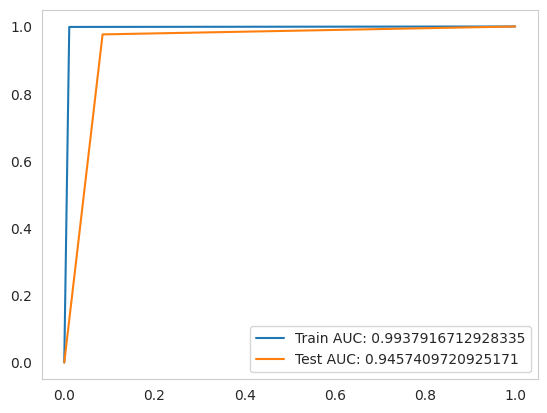

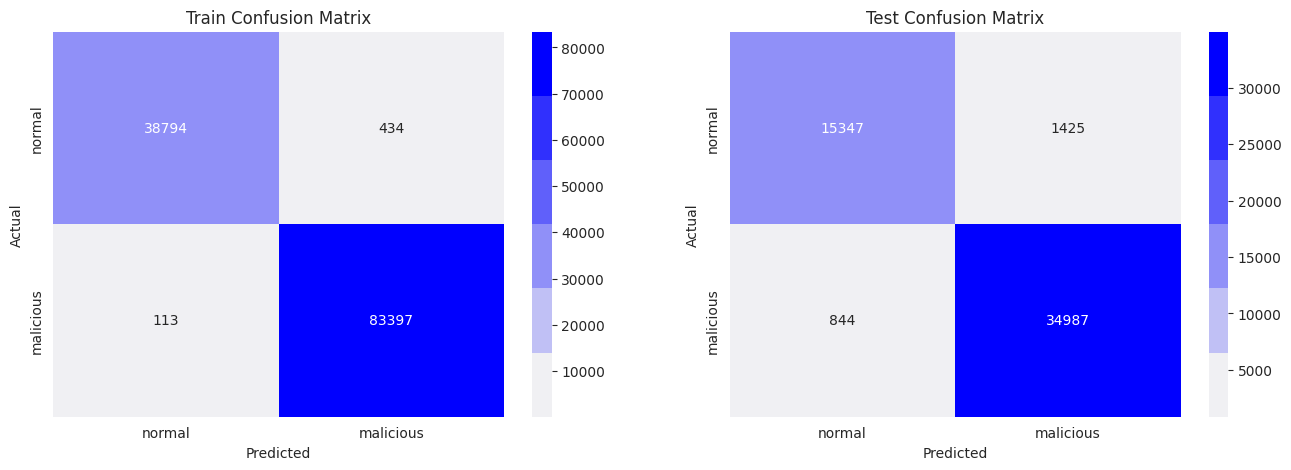

(VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(max_depth=30,
                                                      max_features=15,
                                                      min_samples_split=12,
                                                      n_estimators=300)),
                              ('xgb',
                               XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=0.5,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamm...
               

In [190]:
#vot['AUC'] = vot['AUC'] * 2
vot['total_score'] = vot[['AUC']].sum(axis=1)
vot['weights'] = vot['total_score'] / vot['total_score'].sum()
weights = vot['weights'].tolist()

# Result with voting classifier
v_clf1 = VotingClassifier(
                      estimators=[
                          
                       ('rf', rf_clf)
                      , ('xgb', xgb_clf)
                      , ('dt', dt_clf)]
                      ,voting='soft'
                      , weights=weights
                      , n_jobs=-1)
evaluate_result( "Voting_auc", v_clf1, X_train, y_train, X_test, y_test)

In [191]:
pickle.dump(v_clf1, open(path+'models/v_clf_auc.pkl', 'wb'))

+---------+------------+-------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset |   Model    |        AUC        |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  | Voting_all | 0.993725627152236 | 0.9967195482656629 | 0.9987187163213986 | 0.9947283678215755 | 0.9955270576349623 |
|   Test  | Voting_all | 0.945381330206874 | 0.9684464003985719 | 0.9765007954006307 | 0.9605237873006287 | 0.9566564644602019 |
+---------+------------+-------------------+--------------------+--------------------+--------------------+--------------------+


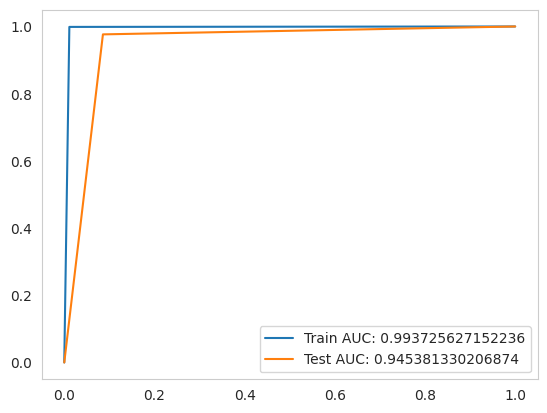

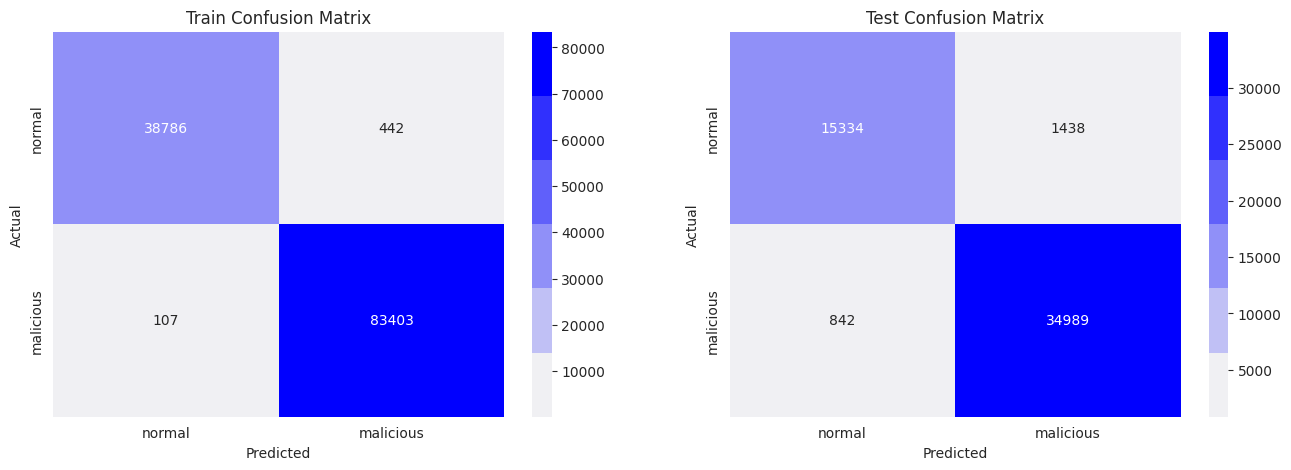

(VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(max_depth=30,
                                                      max_features=15,
                                                      min_samples_split=12,
                                                      n_estimators=300)),
                              ('xgb',
                               XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=0.5,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamm...
               

In [192]:
#vot['AUC'] = vot['AUC'] * 2
vot['total_score'] = vot[['AUC', 'F1-score', 'Recall', 'Precision', 'Accuracy']].sum(axis=1)
vot['weights'] = vot['total_score'] / vot['total_score'].sum()
weights2 = vot['weights'].tolist()

# Result with voting classifier
v_clf2 = VotingClassifier(
                      estimators=[
                          
                       ('rf', rf_clf)
                      , ('xgb', xgb_clf)
                      , ('dt', dt_clf)]
                      ,voting='soft'
                      , weights=weights2
                      , n_jobs=-1)
evaluate_result( "Voting_all", v_clf2, X_train, y_train, X_test, y_test)

In [193]:
pickle.dump(v_clf2, open(path+'models/v_clf_all.pkl', 'wb'))

+---------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Dataset |      Model      |        AUC         |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Train  | Voting_all_auc2 | 0.9937128811544793 | 0.9967135925810847 | 0.9987187163213986 |  0.99471650406698  | 0.9955189101989604 |
|   Test  | Voting_all_auc2 | 0.9453039470349794 | 0.9684356189026498 | 0.9765845217828137 | 0.9604215842345062 | 0.9566374541375967 |
+---------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+


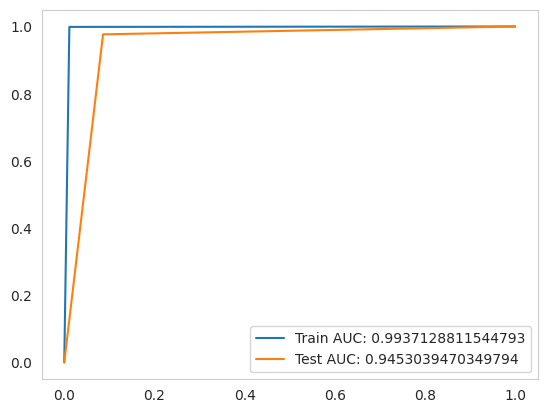

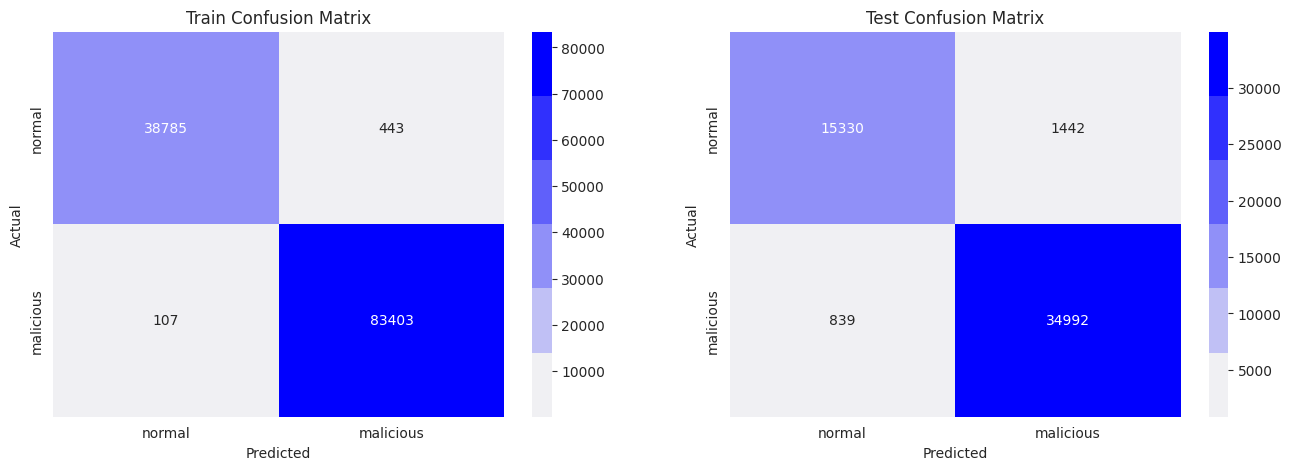

(VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(max_depth=30,
                                                      max_features=15,
                                                      min_samples_split=12,
                                                      n_estimators=300)),
                              ('xgb',
                               XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=0.5,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamm...
               

In [194]:
vot['AUC'] = vot['AUC'] * 2
vot['total_score'] = vot[['AUC', 'F1-score', 'Recall', 'Precision', 'Accuracy']].sum(axis=1)
vot['weights'] = vot['total_score'] / vot['total_score'].sum()
weights3 = vot['weights'].tolist()

# Result with voting classifier
v_clf3 = VotingClassifier(
                      estimators=[                         
                       ('rf', rf_clf)
                      , ('xgb', xgb_clf)
                      , ('dt', dt_clf)]
                      ,voting='soft'
                      , weights=weights3
                      , n_jobs=-1)
evaluate_result( "Voting_all_auc2", v_clf3, X_train, y_train, X_test, y_test)

In [195]:
pickle.dump(v_clf3, open(path+'models/v_clf_all_auc2.pkl', 'wb'))

In [197]:
df = pd.DataFrame(result_dict)
df = df.drop(5)
df = df.drop(6)
df = df.drop(7)
df = df.drop(8)
df = df.drop(9)
df = df.drop(10)
df = df.drop(11)
df = df.drop(12)
df = df.drop(13)
df = df.drop(14)
df = df.drop(15)
df

,Model,AUC,F1-score,Recall,Precision,Accuracy
0,RF,0.939354,0.966922,0.980603,0.953617,0.954299
1,XGB,0.946489,0.968400,0.974603,0.962276,0.956675
2,LR,0.903751,0.953645,0.988697,0.920993,0.934528
3,SVM,0.901585,0.953512,0.991460,0.918362,0.934148
4,DT,0.921472,0.959596,0.982641,0.937607,0.943634
16,Voting_auc,0.945741,0.968592,0.976445,0.960865,0.956866
17,Voting_all,0.945381,0.968446,0.976501,0.960524,0.956656
18,Voting_all_auc2,0.945304,0.968436,0.976585,0.960422,0.956637


In [189]:
pickle.dump(v_clf, open(path+'models/v_clf_auc.pkl', 'wb'))
pickle.dump(v_clf_2, open(path+'models/v_clf_all.pkl', 'wb'))
pickle.dump(v_clf_3, open(path+'models/v_clf_all_auc2.pkl', 'wb'))

NameError: ignored

,Model,AUC,F1-score,Recall,Precision,Accuracy
0,RF,0.939354,0.966922,0.980603,0.953617,0.954299
1,XGB,0.946489,0.968400,0.974603,0.962276,0.956675
2,LR,0.903751,0.953645,0.988697,0.920993,0.934528
3,SVM,0.901585,0.953512,0.991460,0.918362,0.934148
4,DT,0.921472,0.959596,0.982641,0.937607,0.943634


In [ ]:
pickle.dump(v_clf, open(path+'models/v_clf.pkl', 'wb'))

In [ ]:
y_test.shape

(43836,)

In [ ]:
X_test.shape

(43836, 181)